# Workflow to Validate NISAR L2 Transient Displacement Requirements

**Original code authored by:** NISAR Science Team Members and Affiliates  

*May 13, 2022*

*NISAR Solid Earth Team*

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

<hr/>

## Table of Contents: <a id='TOC'></a>

[**Environment Setup**](#setup)
- [Load Python Packages](#load_packages)
- [Define CalVal Site and Parameters](#set_calval_params)
- [Set Directories and Files](#set_directories)

[**1. Download and Prepare Interferograms**](#prep_ifg)
[Executed in ARIA_prep]

[**2. Generate Interferogram Stack**](#transient_gen_ifg)
- [2.1.  Validate/Modify Interferogram Network](#transient_crop_ifg)

[**3. Optional Corrections**](#opt_correction)
- [3.1. Solid Earth Tide Correction](#solid_earth)
- [3.2 Ionosphere Correction](#iono_corr)
- [3.3. Tropospheric Delay Correction](#tropo_corr)
- [3.4. Phase Deramping ](#phase_deramp)
- [3.5. Topographic Residual Correction ](#topo_corr)

[**4. Make GNSS LOS Measurements**](#transient_gnss_los)
- [4.3. Find Collocated GNSS Stations](#transient_co_gnss)  
- [4.4. Make GNSS LOS Measurements](#transient_gnss_los2) 
- [4.5. Make GNSS and InSAR Relative Displacements](#transient_gnss_insar)

[**5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#transient_validation1)
- [5.1. Pair up GNSS stations and make measurement residuals](#transient_pair1)
- [5.2. Validate the requirement based on binned measurement residuals](#transient_bin1)
- [5.3. Result visulazation](#transient_result1)
- [5.3. Conclusion](#transient_conclusion1)

[**6. NISAR Validation Approach 2: Noise Level Validation**](#transient_validation2)
- [6.1. Randomly sample pixels and pair them up](#transient_pair2)
- [6.2. Validate the requirement based on binned measurement residuals](#transient_bin2)
- [6.3. Result visulazation](#transient_result2)
- [6.3. Conclusion](#transient_conclusion2)

[**Appendix: GNSS Position Plots**](#transient_appendix)

<hr/>

<br>
<hr>

<a id='#setup'></a>
## Environment Setup

### Load Python Packages <a id='#load_packages'></a>

In [1]:
# Load packages
import copy
import glob
import math
import os
import random
import subprocess
from datetime import datetime as dt
from pathlib import Path
import json

import numpy as np
import pandas as pd
import pyproj
from matplotlib import pyplot as plt
from mintpy import smallbaselineApp
from mintpy.objects import gnss
from mintpy.utils import readfile, utils as ut
from mintpy.cli import view

from solid_utils.sampling import load_geo, samp_pair
from solid_utils.plotting import display_validation_table, \
    display_coseismic_validation as display_transient_validation
from solid_utils.corrections import run_cmd, pairwise_stack_from_timeseries
from solid_utils.saving import save_results

### Define Calval Site and Parameters <a id='set_calval_params'></a>

In [2]:
# === Basic Configuration ===
site = "test"
requirement = "Transient"
dataset = 'ARIA_S1_new' # For Sentinel-1 testing with aria-tools
aria_gunw_version = "3_0_1"

rundate = "20240909"  # Date of this Cal/Val run
version = "1"         # Version of this Cal/Val run
custom_sites = "/home/jovyan/my_sites.txt"  # Path to custom site metadata

# === Username Detection / Creation ===
user_file = "/home/jovyan/me.txt"
if os.path.exists(user_file):
    with open(user_file, "r") as f:
        you = f.readline().strip()
else:
    you = input("Please type a username for your Cal/Val outputs: ").strip()
    with open(user_file, "w") as f:
        f.write(you)

# === Load Cal/Val Site Metadata ===
try:
    with open(custom_sites, "r") as f:
        sitedata = json.load(f)
    site_info = sitedata["sites"][site]
except (FileNotFoundError, json.JSONDecodeError) as e:
    raise RuntimeError(f"Failed to load site metadata from {custom_sites}: {e}")
except KeyError:
    raise ValueError(f"Site ID '{site}' not found in {custom_sites}")

print(f"Loaded site: {site}")

# === Plot Parameters ===
vmin, vmax = -50, 50  # mm
cmap = plt.get_cmap('RdBu')

Loaded site: test


### Set Directories and Files <a id='set_directories'></a>

In [3]:
# === Define Cal/Val Directory Structure ===
BASE_DIR = "/scratch/nisar-st-calval-solidearth"
site_dir = os.path.join(BASE_DIR, dataset, site)
work_dir = os.path.join(site_dir, requirement, you, rundate, f"v{version}")
gunw_dir = os.path.join(site_dir, "products")
mintpy_dir = os.path.join(work_dir, "MintPy")
weather_dir = os.path.join(site_dir)

# === Log Directory Paths ===
print(f"  Work directory: {work_dir}")
print(f"  GUNW directory: {gunw_dir}")
print(f"MintPy directory: {mintpy_dir}")

# === Check MintPy Directory Existence ===
if not os.path.exists(mintpy_dir):
    print("\nERROR: Stop! MintPy processing directory is missing.")
    print("This may indicate the prep notebook has not been run.")
    print("Missing path:", mintpy_dir, "\n")
else:
    os.chdir(mintpy_dir)

    # === Set Expected MintPy Filenames ===
    ifgs_file = os.path.join(mintpy_dir, "inputs/ifgramStack.h5")
    geom_file = os.path.join(mintpy_dir, "inputs", "geometryGeo.h5")
    config_file = os.path.join(mintpy_dir, site_info.get('calval_location') + '.cfg')

  Work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1
  GUNW directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/products
MintPy directory: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/MintPy


In [4]:
configs = readfile.read_template(config_file)
print('#' * 10, "MintPy Configs", '#' * 10)
for key, value in configs.items():
    print(f"{key}: {value}")

########## MintPy Configs ##########
mintpy.load.processor: aria
mintpy.compute.cluster: local
mintpy.compute.numWorker: auto
mintpy.load.unwFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/stack/unwrapStack.vrt
mintpy.load.corFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/stack/cohStack.vrt
mintpy.load.connCompFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/stack/connCompStack.vrt
mintpy.load.demFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/DEM/glo_90.dem
mintpy.load.incAngleFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/incidenceAngle/*.vrt
mintpy.load.azAngleFile: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/azimuthAngle/*.vrt
mintpy.load.waterMaskFile: auto
mintpy.topographicResidual.pixelwiseGeometry: no
mintpy.troposphericDelay.method: no
mintp

<br>
<hr>

<a id='#prep_ifg'></a>
## 1. Download and Prepare Interferograms 
Executed in *ARIA_prep* notebook

<br>
<hr>

<a id='#transient_gen_ifg'></a>
## 2. Generation of Time Series from Interferograms

### 2.1. Validate/Modify Interferogram Network <a id='transient_crop_ifg'></a>

**NOTE:** If the interferogram has a resolution lower than 100 m, we need multi-look the interferogram phase values before calculating the empirical semivarigram.

Load the date of interferograms into Python:

In [5]:
# Retrieve available interferogram date pairs
ifgs_date = readfile.read(ifgs_file,datasetName='date')[0]

# Report all available date pairs
print(f"Total {len(ifgs_date)} interferograms available")
for pair in ifgs_date:
    print(f"{pair[0].decode()}-{pair[1].decode()}")

Total 15 interferograms available
20190112-20190124
20190112-20190205
20190112-20190217
20190124-20190205
20190124-20190217
20190124-20190301
20190205-20190217
20190205-20190301
20190205-20190313
20190217-20190301
20190217-20190313
20190217-20190325
20190301-20190313
20190301-20190325
20190313-20190325


In [6]:
# Format date strings into Python datetime objects
_ifgs_date = np.empty_like(ifgs_date, dtype=dt)
for i in range(ifgs_date.shape[0]):
    start_date = ifgs_date[i,0].decode()
    end_date = ifgs_date[i,1].decode()
    start_date = dt.strptime(start_date, "%Y%m%d")
    end_date = dt.strptime(end_date, "%Y%m%d")
    _ifgs_date[i] = [start_date, end_date]

# Update list of interferogram dates
ifgs_date = _ifgs_date

# Remove temporary list to avoid future confusion
del _ifgs_date

Remove interferograms with time interval other than 12 days:

In [7]:
# Determine which interferograms to exclude based on 12-day criterion
del_row_index = []
for i in range(ifgs_date.shape[0]):
    time_interval = (ifgs_date[i,1]-ifgs_date[i,0]).days
    if time_interval != 12:
        del_row_index.append(i)
while i<ifgs_date.shape[0]-1:
    if ifgs_date[i,1]==ifgs_date[i+1,0]:
        del_row_index.append(i+1)
        i = i+2
    else:
        i = i+1

# Remove non-12-day interferograms
ifgs_date = np.delete(ifgs_date, del_row_index, 0)

# Report 12-day date pairs
print(f"{len(ifgs_date)} interferograms with 12-day baselines")
for pair in ifgs_date:
    print(f"{pair[0].strftime('%Y%m%d')}-{pair[1].strftime('%Y%m%d')}")

6 interferograms with 12-day baselines
20190112-20190124
20190124-20190205
20190205-20190217
20190217-20190301
20190301-20190313
20190313-20190325


Identify independent interferograms (i.e., selected inteferograms do NOT share common dates):

In [8]:
# Determine which interferograms to exclude based on independence criterion
del_row_index = []
i = 0
while i<ifgs_date.shape[0]-1:
    if ifgs_date[i,1]==ifgs_date[i+1,0]:
        del_row_index.append(i+1)
        i = i+2
    else:
        i = i+1

# Remove non-independent interferograms from list
ifgs_date = np.delete(ifgs_date, del_row_index, 0)

# Report independent date pairs
print(f"{len(ifgs_date)} independent interferograms (no common date shared)")
for pair in ifgs_date:
    print(f"{pair[0].strftime('%Y%m%d')}-{pair[1].strftime('%Y%m%d')}")

3 independent interferograms (no common date shared)
20190112-20190124
20190205-20190217
20190301-20190313


Load the coherence data sets of selected interferograms into memory. Hold off loading the phase values until optional correction layers have been applied.

In [9]:
# Construct dataset-layer names as lists
coherenceName = [f"coherence-{date[0].strftime('%Y%m%d')}_{date[1].strftime('%Y%m%d')}"
                 for date in ifgs_date]

# Read average filtered spatial coherence
insar_coherence, _ = readfile.read(ifgs_file, datasetName=coherenceName)

<a id='transient_opt_correction'></a>
## 3. Optional Interferogram Correction

Phase distortions related to solid earth and ocean tidal effects as well as those due to temporal variations in the vertical stratification of the atmosphere can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

### 3.1. Solid Earth Tides Correction <a id='solid_earth'></a>

Not implemented.

In [10]:
# Automatically set do_SET to False
site_info['do_SET'] = "False"

### 3.2 Ionosphere Correction <a id='iono_corr'></a>

Determine whether the ionosphere correction will be applied.

In [11]:
if 'do_iono' in site_info.keys() and site_info.get('do_iono') != "False":
    # Input ionosphere stack file  
    iono_stack_file = f"{mintpy_dir}/inputs/ionStack.h5"

    # Check if iono correction file exists
    if os.path.exists(iono_stack_file):
        # Specify file paths
        dirpath, filename = os.path.split(ifgs_file)
        name, ext = os.path.splitext(filename)
        output_ifgs = os.path.join(dirpath, f"{name}_iono{ext}")
    else:
        site_info['do_iono'] = "False"
else:
    site_info['do_iono'] = "False"
    print('#'*10, 'Ionosphere Correction set to False', '#'*10)

########## Ionosphere Correction set to False ##########


The `ionStack.h5` dataset is written using the convention ref_repeat and is stored in units of radians. Therefore, the ionosphere correction layers can be directly subtracted from the ifgramStack.h5 unwrapped phase values to apply the ionosphere correction.

In [12]:
# Apply correction if flag is set to True
if site_info.get('do_iono')!= "False":
    # Run difference
    run_cmd(f"diff.py {ifgs_file} {iono_stack_file} -o {output_ifgs}",
            desc="Apply iono correction to IFG stack")
    
    # Update filename
    ifgs_file = output_ifgs
else:
    print('#'*10, 'Ionosphere Correction set to False', '#'*10)

########## Ionosphere Correction set to False ##########


In [13]:
# Visualize the corrections
if site_info.get('do_iono') != "False":
    view.main([iono_stack_file, '-c', 'RdBu_r'])
else: 
    print('#'*10, 'Ionosphere Correction set to False', '#'*10)

########## Ionosphere Correction set to False ##########


In [14]:
# Visualize the corrected interferograms
if site_info.get('do_iono') != "False":
    view.main([ifgs_file, '-c', 'RdBu_r'])
else: 
    print('#'*10, 'Ionosphere Correction set to False', '#'*10)

########## Ionosphere Correction set to False ##########


### 3.3. Tropospheric Delay Correction <a id='tropo_corr'></a>

Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

Tropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

In [15]:
if 'do_tropo' in site_info.keys() and site_info.get("do_tropo") != "False":
    if site_info.get("tropo_model") != "HRRR":
        # ERA5-based correction
        tropo_source = "ERA5"
        tropo_cor_file = os.path.join(mintpy_dir, "inputs", f"{tropo_source}.h5")

    else:
        # HRRR-based correction
        tropo_source = "HRRR_ARIA"
        tropo_cor_file = os.path.join(mintpy_dir, "inputs", f"{tropo_source}.h5")

    print(f"Troposphere Correction dataset: {tropo_cor_file:s}")

    # Check it tropo correction file exists
    if os.path.exists(tropo_cor_file):
        dirpath, filename = os.path.split(ifgs_file)
        name, ext = os.path.splitext(filename)
        output_ifgs = os.path.join(dirpath, f"{name}_{tropo_source}{ext}")
        print('#'*10, 'Troposphere Correction set to True', '#'*10)
    else:
        site_info['do_tropo'] = "False"

else:
    site_info['do_tropo'] = "False"

if site_info['do_tropo'] == "False":
    print("#" * 10, "Troposphere Correction set to False", "#" * 10)

########## Troposphere Correction set to False ##########


Troposphere correction layer datasets are stored as time-series (one date per acquisition) and in units of meters. To apply the troposphere delay corrections to the `ifgramStack.h5` files, the differential layers must be computed in ref_repeat format, and scaled to units of radians. This is done using the `create_tropo_pairs` function.

In [16]:
# Create stack of troposphere correction layer pairs following the above sign convention
if site_info.get('do_tropo')!= "False":
    tropo_stack_file = pairwise_stack_from_timeseries(ifgs_file, tropo_cor_file)

In [17]:
# Apply correction if flag is set to True
if site_info.get('do_tropo')!= "False":
    # Run difference
    run_cmd(f"diff.py {ifgs_file} {tropo_stack_file} -o {output_ifgs}",
            desc="Apply tropo correction to IFG stack")
    
    # Update filename
    ifgs_file = output_ifgs
else:
    print('#'*10, 'Troposphere Correction set to False', '#'*10)

########## Troposphere Correction set to False ##########


In [18]:
# Visualize the corrections
if site_info.get('do_tropo') != "False":
    view.main([tropo_stack_file, '-c', 'RdBu_r'])
else: 
    print('#'*10, 'Troposphere Correction set to False', '#'*10)

########## Troposphere Correction set to False ##########


In [19]:
# Visualize the corrected interferograms
if site_info.get('do_tropo') != "False":
    view.main([ifgs_file, '-c', 'RdBu_r'])
else: 
    print('#'*10, 'Troposphere Correction set to False', '#'*10)

########## Troposphere Correction set to False ##########


### 3.4. Phase Deramping <a id='phase_deramp'></a>

Not implemented.

### 3.5. Topographic Residual Correction <a id='topo_corr'></a>

Not implemented.

Preliminary summary: we have load all data we need for processing:
- `atr`: metadata, including incident angle, longitude and latitude step width, etc;
- `insar_displacement`: LOS measurement from InSAR;
- `insar_coherence`: coherence value of the interferograms:
- `ifgs_date`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_gnss_los'></a>
# 4. Make GNSS and InSAR Relative Displacements

Read the unwrapped phase values into memory and convert from phase in radians, to displacement in mm. Change default missing phase values in interferograms from 0.0 to `np.nan`.

<div class="alert alert-block alert-info">
    <b>Note:</b> This notebook uses the sign convention <b>ref_repeat</b> (e.g., 20190124_20190112). That is, range decrease is positive and therefore "up" is positive. In contrast, MintPy interferograms follow the opposite convention (range increase is positive).
</div>

In [20]:
# Construct dataset-layer names as lists
unwrapPhaseName = [f"unwrapPhase-{date[0].strftime('%Y%m%d')}_{date[1].strftime('%Y%m%d')}"
                   for date in ifgs_date]

# Read unwrapped phase from selected interferograms
ifgs_unw, insar_metadata = readfile.read(ifgs_file, datasetName=unwrapPhaseName)

# Convert phase to displacement in m and switch convention to positive range decrease
insar_displacement = -ifgs_unw*float(insar_metadata['WAVELENGTH']) / (4*np.pi)

# Convert displacement units from m to mm
insar_displacement = insar_displacement * 1000.

# Set masked pixels to NaN
insar_displacement[insar_displacement==0.0] = np.nan

# Clean up phase-only IFGs to avoid future confusion
del ifgs_unw

### 4.1. Not Used

### 4.2. Not Used <a id='empty'></a>

### 4.3. Find Collocated GNSS Stations <a id='transient_co_gnss'></a>

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

Get space and time range for searching GNSS station:

In [21]:
# Spatial metadata
length, width = int(insar_metadata['LENGTH']), int(insar_metadata['WIDTH'])
lat_step = float(insar_metadata['Y_STEP'])
lon_step = float(insar_metadata['X_STEP'])
N = float(insar_metadata['Y_FIRST'])
W = float(insar_metadata['X_FIRST'])
S = N+lat_step*(length-1)
E = W+lon_step*(width-1)

# Temporal metadata
start_date_gnss = ifgs_date[0,0]
end_date_gnss = ifgs_date[-1,-1]

Search for collocated GNSS stations:

In [22]:
# GNSS processing source
if 'gnss_source' in sitedata['sites'][site]:
    gnss_source = sitedata['sites'][site]['gnss_source']
else:
    gnss_source = 'UNR'
print(f"GNSS processing source: {gnss_source:s}")

# Start and end dates
start_date = start_date_gnss.strftime('%Y%m%d')
end_date = end_date_gnss.strftime('%Y%m%d')

# Query GNSS sites within geographic and date range
site_names, site_lats, site_lons = gnss.search_gnss(SNWE=(S,N,W,E),
                                                    start_date=start_date,
                                                    end_date=end_date,
                                                    source=gnss_source)
os.chdir(work_dir)
site_names = [str(stn) for stn in site_names]
print(f"Initial list of {len(site_names)} stations used in analysis:")
print(site_names)

GNSS processing source: UNR
load 22275 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (34.660027727999996, 35.60002848, -116.620093296, -114.390091512): [31]
keep sites with end_date >= 20190112: [27]
keep sites with start_date <= 20190313: [26]
keep sites with # of solutions >= 50: [26]
['AZBH' 'AZFM' 'BKAP' 'CAB5' 'CDMT' 'GMRC' 'HCMN' 'HOME' 'I40A' 'LDSW'
 'NDAP' 'NVLA' 'NVSL' 'P603' 'P611' 'P614' 'P617' 'P618' 'P619' 'P621'
 'P622' 'P625' 'P626' 'PIUT' 'RAGG' 'THUM']
Initial list of 26 stations used in analysis:
['AZBH', 'AZFM', 'BKAP', 'CAB5', 'CDMT', 'GMRC', 'HCMN', 'HOME', 'I40A', 'LDSW', 'NDAP', 'NVLA', 'NVSL', 'P603', 'P611', 'P614', 'P617', 'P618', 'P619', 'P621', 'P622', 'P625', 'P626', 'PIUT', 'RAGG', 'THUM']


### 4.4. Get GNSS Position Time Series <a id='gps_ts'></a>

In this step, the 3D GNSS observations are projected into the satellite LOS. The InSAR observations are averaged over a 3$\times$3 pixel window around the station positions.

<div class="alert alert-block alert-info">
    <b>Note:</b> The number of pixels used in calculating the averaged phase values at the GPS location depends on the resolution of input data.
</div>

Get daily position solutions for GNSS stations:

In [23]:
# Empty dictionaries to store InSAR and GNSS data
displacement = {}
gnss_time_series = {}
gnss_time_series_std = {}
bad_stn = {}  # stations to toss
pixel_radius = 3  # number of InSAR pixels to average for comparison with GNSS

# Loop through GNSS sites
for counter, site_name in enumerate(site_names):
    gnss_stn = gnss.get_gnss_class(gnss_source)(site = site_name)
    gnss_stn.open(print_msg=False)

    # Download / read the GNSS site displacement and dates
    gnss_stn.read_displacement()
    dates = gnss_stn.dates

    # Count number of dates in time range by looping through interferograms
    for ifg_ndx in range(insar_displacement.shape[0]):
        # Days in interferogram range (should be 12 based on above filtering)
        start_date = ifgs_date[ifg_ndx,0]
        end_date = ifgs_date[ifg_ndx,-1]
        range_days = (end_date - start_date).days

        # Count number of GNSS epochs in IFG date range
        gnss_count = np.histogram(dates, bins=[start_date,end_date])
        gnss_count = int(gnss_count[0])

        # Select GNSS stations based on data completeness
        # Here we hope to select stations with data frequency of 1 day and no interruption
        if range_days == gnss_count - 1:
            # If start_date in dates and end_date in dates, retrieve displacement data
            (disp_gnss_time_series,
             disp_gnss_time_series_std,
             site_latlon) = gnss_stn.get_los_displacement(geom_file,
                                                          start_date=start_date.strftime('%Y%m%d'),
                                                          end_date=end_date.strftime('%Y%m%d'))[1:4]

            # Compute station pixel coordinates
            x_value = round((site_latlon[1] - W)/lon_step)
            y_value = round((site_latlon[0] - N)/lat_step)

            # Displacement from insar observation in the gnss station, averaged
            # Caution: If you expand the radius parameter farther than the bounding grid it will break. 
            disp_insar = insar_displacement[ifg_ndx,
                                            y_value-pixel_radius:y_value+pixel_radius+1, 
                                            x_value-pixel_radius:x_value+pixel_radius+1]

            # Check values in InSAR displacement series are valid
            if np.isfinite(disp_insar).sum() == 0:
                # Ignore station if infinite values
                break

            # Compute mean of window around InSAR pixel, ignoring NaNs
            disp_insar = np.nanmean(disp_insar)

            # Scale GNSS displacement values from m to mm
            disp_gnss_time_series = disp_gnss_time_series*1000
            disp_gnss_time_series_std = disp_gnss_time_series_std*1000

            # Store time-series displacements to dicts, labeled by IFG index and site name
            gnss_time_series[(ifg_ndx, site_name)] = disp_gnss_time_series
            gnss_time_series_std[(ifg_ndx, site_name)] = disp_gnss_time_series_std
            displacement[(ifg_ndx, site_name)] = list(site_latlon)
            disp_gnss = disp_gnss_time_series[-1] - disp_gnss_time_series[0]

            displacement[(ifg_ndx, site_name)].append(disp_gnss)
            displacement[(ifg_ndx, site_name)].append(disp_insar)
        else:
            try:
                bad_stn[ifg_ndx].append(site_name)
            except:
                bad_stn[ifg_ndx] = [site_name]

reading time and displacement in east/north/vertical direction


/tmp/ipykernel_5312/2222139143.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gnss_count = int(gnss_count[0])


reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical direction
reading time and displacement in east/north/vertical di

Do some data structure transformation:

In [24]:
# Rearrange GNSS TS and disp values by IFG number and site name
gnss_time_series = dict(sorted(gnss_time_series.items()))
gnss_time_series_std = dict(sorted(gnss_time_series_std.items()))
displacement = dict(sorted(displacement.items()))
bad_stn = dict(sorted(bad_stn.items()))

In [25]:
# Convert GNSS TS dictionaries to pandas dataframes
gnss_time_series = pd.DataFrame.from_dict(gnss_time_series)
gnss_time_series_std = pd.DataFrame.from_dict(gnss_time_series_std)

In [26]:
# Convert displacement dictionaries to pandas dataframes
displacement = pd.DataFrame.from_dict(displacement, orient='index',
                                      columns=['lat','lon','gnss_disp','insar_disp'])

# Organize by IFG index and site name
displacement.index = pd.MultiIndex.from_tuples(displacement.index, names=['ifg index','station'])

If there are less than 3 GNSS stations, don't conduct comparison:

In [27]:
# Drop IFGs with less than three stations
drop_index = []
for i in displacement.index.get_level_values(0).unique():
    if len(displacement.loc[i]) < 3:
        drop_index.append(i)
displacement=displacement.drop(drop_index)

# ifgs_date after drop for approach 1
ifgs_date_ap1=np.delete(ifgs_date,drop_index,axis=0)

All data needed for approach 1:

In [28]:
displacement

lat              lon  gnss_disp  insar_disp
ifg index station                                                   
0         AZBH     35.107494  -114.6049864865  -3.567635   33.339771
          AZFM     34.852237  -114.5951040115  -3.625732   40.347820
          BKAP     35.287048  -116.0804234276  -6.054016   32.927849
          CDMT     34.829468  -116.3359298957  -3.944855   55.523899
          HCMN     34.754774   -116.430073364  -4.718124   54.805042
...                      ...              ...        ...         ...
2         P621     35.472761   -115.543949681  -3.767303  -29.776190
          P622     35.162992  -115.3658640845  13.729065  -21.671978
          P625     34.844444  -114.9651435269  -3.135864  -16.313719
          P626     35.291120  -115.2382768217   7.027328  -36.779552
          RAGG     34.683140  -116.1514577581   7.109192  -27.018782

[64 rows x 4 columns]

<div class="alert alert-block alert-info">
    <b>Note:</b> A more general critterion is needed for GNSS station selection. Here the stations with uninterrupted data are selected while, in Secular Requirement Validation, stations are selected by data completeness and standard variation.
</div>

### 4.6. Re-reference GNSS and InSAR <a id='reference'></a>

Here we randomly select one reference site and make both the GNSS and InSAR measurements relative to that reference to remove a constant offset.

In [29]:
# Read reference site
gnss_ref_site_name = sitedata['sites'][site]['gps_ref_site_name']
print(f"Using reference site: {gnss_ref_site_name:s}")

# Loop through interferograms to re-reference
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Determine reference site
    if gnss_ref_site_name in ['auto', 'random']:
        # Choose random GNSS site
        gnss_ref_site_name = random.choice(displacement.loc[ifg_ndx].index.unique())
        print(f"Ifg {ifg_ndx} reference site: {gnss_ref_site_name}")

    # Remove reference site values from GNSS and InSAR displacements
    displacement.loc[ifg_ndx, 'gnss_disp'] = displacement.loc[ifg_ndx, 'gnss_disp'].values \
            - displacement.loc[(ifg_ndx, gnss_ref_site_name), 'gnss_disp']
    displacement.loc[ifg_ndx, 'insar_disp'] = displacement.loc[ifg_ndx, 'insar_disp'].values \
            - displacement.loc[(ifg_ndx, gnss_ref_site_name), 'insar_disp']

    # Reference point pixel coordinates
    ref_x_value = round((displacement.loc[(ifg_ndx, gnss_ref_site_name),'lon'] - W)/lon_step)
    ref_y_value = round((displacement.loc[(ifg_ndx, gnss_ref_site_name),'lat'] - N)/lat_step)

    # InSAR displacement values at site location for re-referencing
    ref_disp_insar = insar_displacement[ifg_ndx,
                                        ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                        ref_x_value-pixel_radius:ref_x_value+1+pixel_radius]

    # Re-referenced mean value at site location
    ref_disp_insar = np.nanmean(ref_disp_insar)

    # Subtract reference value from InSAR displacement
    insar_displacement[ifg_ndx] -= ref_disp_insar

Using reference site: P622


Plot GNSS stations on InSAR displacement fields

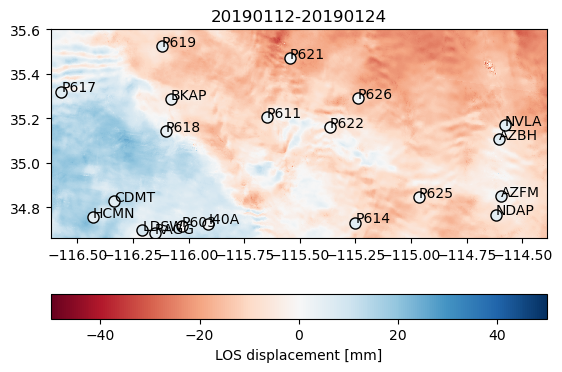

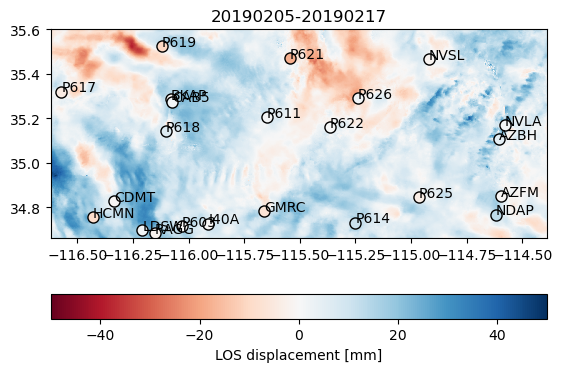

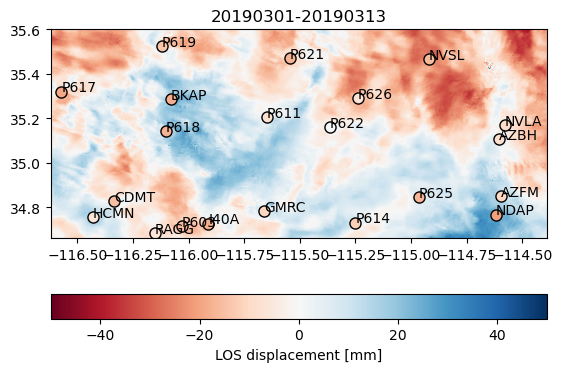

In [30]:
# Set color values
cmap_obj = copy.copy(plt.get_cmap(cmap))

vmin = vmin if vmin is not None else np.nanmin(insar_displacement)
vmax = vmax if vmax is not None else np.nanmax(insar_displacement)

# Loop through interferograms
gnss_insar_figs = []
for ifg_ndx in displacement.index.get_level_values(0).unique():
    fig, ax = plt.subplots()
    img1 = ax.imshow(insar_displacement[ifg_ndx],
                     cmap=cmap_obj, vmin=vmin, vmax=vmax, interpolation='nearest',
                     extent=(W, E, S, N))
    ax.set_title(f"{ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')}")
    cbar1 = fig.colorbar(img1, ax=ax, orientation='horizontal')
    cbar1.set_label('LOS displacement [mm]')

    for site_name in displacement.loc[ifg_ndx].index:
        lon, lat = displacement.loc[(ifg_ndx, site_name), 'lon'], displacement.loc[(ifg_ndx, site_name), 'lat']
        color = cmap((displacement.loc[(ifg_ndx, site_name), 'gnss_disp']-vmin)/(vmax-vmin))
        ax.scatter(lon, lat, s=8**2, color=color, edgecolors='k')
        ax.annotate(site_name, (lon,lat), color='black')

    # Append figure to list
    gnss_insar_figs.append(fig)

<br>
<hr>

<a id='validation1'></a>
## 5. Validation Method 1: GNSS-InSAR Direct Comparison

<a id='transient_pair1'></a>
### 5.1, 5.2. Make GNSS-InSAR Velocity Residuals at GNSS Station Locations

We first pair up all GNSS stations and compare the relative measurement from both GNSS and InSAR. 

In [31]:
# Empty dictionaries for GNSS and InSAR measurements, etc.
insar_disp = {}
gnss_disp = {}
ddiff_dist = {}
ddiff_disp = {}
abs_ddiff_disp = {}

# Define ellipsoid for distance calculation
geod = pyproj.Geod(ellps="WGS84")

# Loop through interferograms
for ifg_ndx in displacement.index.get_level_values(0).unique():
    displacement_i = displacement.loc[ifg_ndx]
    insar_disp_i = []
    gnss_disp_i = []
    ddiff_dist_i = []
    ddiff_disp_i = []

    # Loop through site pairs
    for sta1 in displacement_i.index:
        for sta2 in displacement_i.index:
            if sta2 == sta1:
                break

            # Compute InSAR and GNSS displacement residuals
            insar_disp_i.append(displacement_i.loc[sta1, 'insar_disp'] \
                                - displacement_i.loc[sta2, 'insar_disp'])
            gnss_disp_i.append(displacement_i.loc[sta1, 'gnss_disp'] \
                               - displacement_i.loc[sta2, 'gnss_disp'])

            # Compute double-difference residual
            ddiff_disp_i.append(gnss_disp_i[-1] - insar_disp_i[-1])

            # Compute distance between sites
            _, _, distance = geod.inv(displacement_i.loc[sta1,'lon'], displacement_i.loc[sta1,'lat'],
                                      displacement_i.loc[sta2,'lon'], displacement_i.loc[sta2,'lat'])
            distance = distance / 1000  # convert unit from m to km

            # Record double difference
            ddiff_dist_i.append(distance)

    # Record all site-to-site values within an IFG
    insar_disp[ifg_ndx] = np.array(insar_disp_i)
    gnss_disp[ifg_ndx] = np.array(gnss_disp_i)
    ddiff_dist[ifg_ndx] = np.array(ddiff_dist_i)
    ddiff_disp[ifg_ndx] = np.array(ddiff_disp_i)
    abs_ddiff_disp[ifg_ndx] = abs(np.array(ddiff_disp_i))

Plot Absolute Displacement Residuals As a Function of Distance:

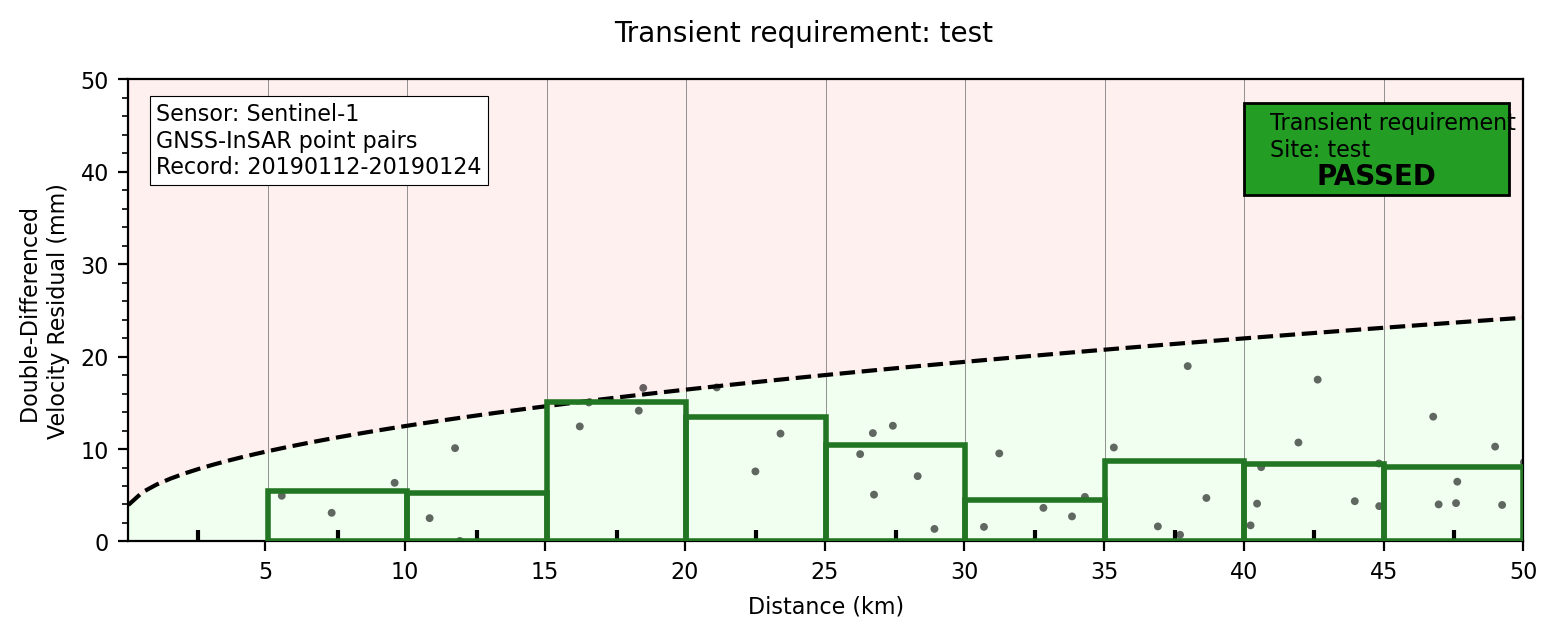

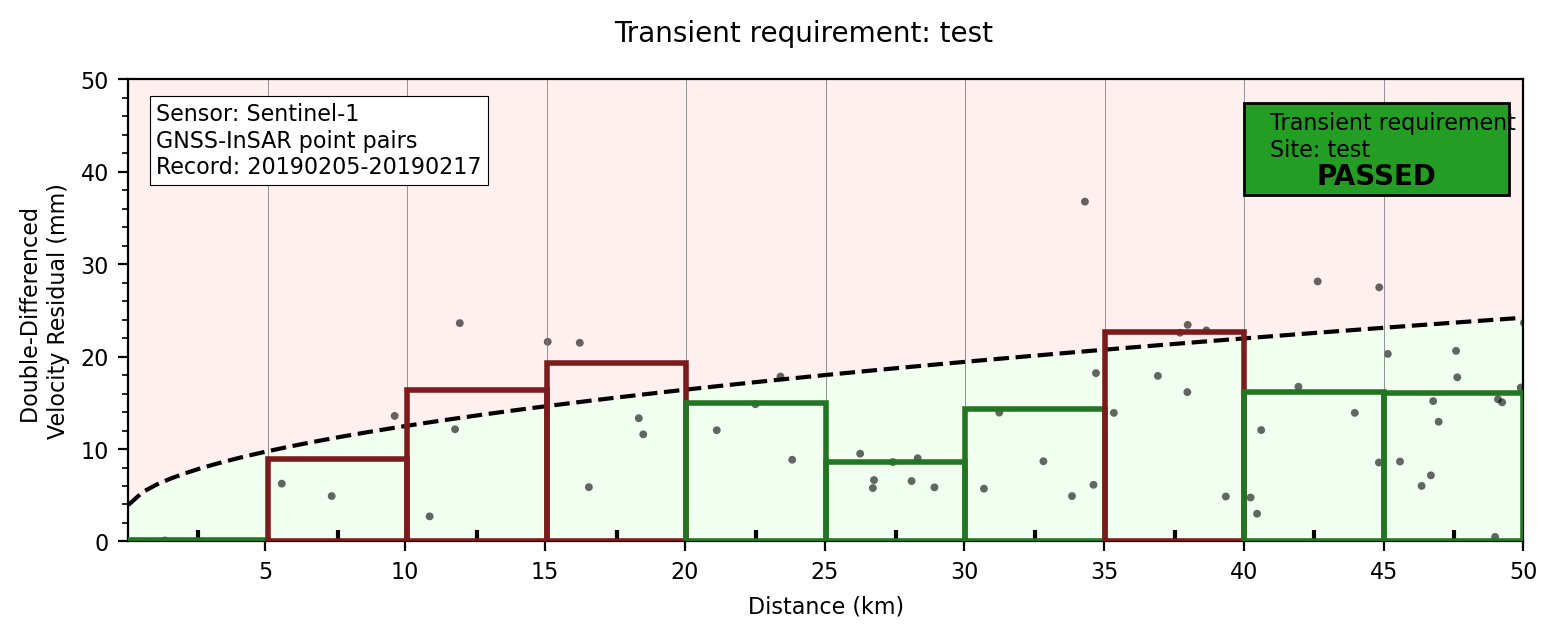

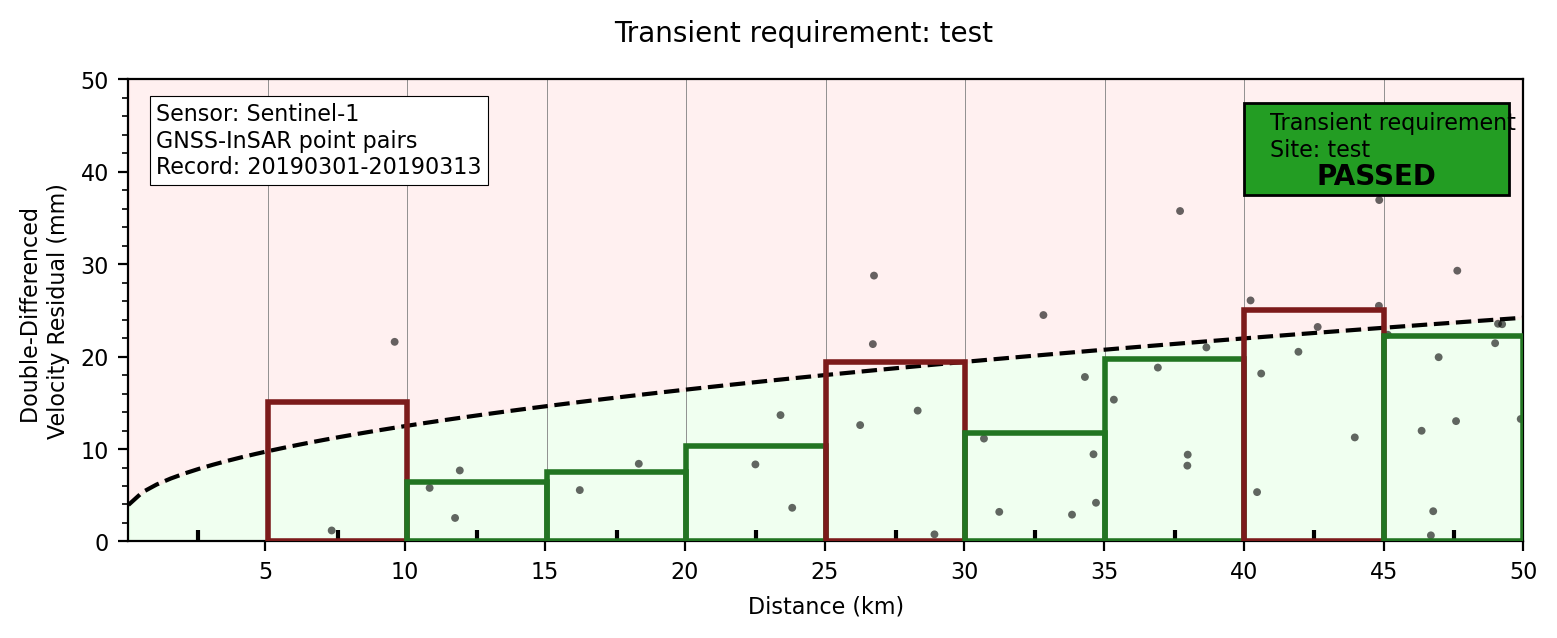

In [32]:
# Set requirement thresholds
transient_distance_rqmt = (0.1, 50)  # distances for evaluation
transient_threshold_rqmt = lambda L: 3 * (1 + np.sqrt(L))  # coseismic threshold in mm

n_bins = 10  # number of distance bins for analysis
threshold = 0.683  # fraction of Gaussian normal distribution for pass/fail

# Loop through interferograms
method1_validation_figs = []
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Start and end dates as strings
    start_date = ifgs_date[ifg_ndx,0].strftime('%Y%m%d')
    end_date = ifgs_date[ifg_ndx,1].strftime('%Y%m%d')

    # Validation figure and assessment
    _, validation_fig_method1 = display_transient_validation(ddiff_dist[ifg_ndx], abs_ddiff_disp[ifg_ndx],
                                                             site, start_date, end_date,
                                                             requirement=transient_threshold_rqmt,
                                                             distance_rqmt=transient_distance_rqmt,
                                                             n_bins=n_bins,
                                                             threshold=threshold,
                                                             sensor='Sentinel-1',
                                                             validation_type=requirement.lower(),
                                                             validation_data='GNSS')
    method1_validation_figs.append(validation_fig_method1)

In [33]:
# Reformat double differences as list
ddiff_dist_ap1 = list(ddiff_dist.values())
abs_ddiff_disp_ap1 = list(abs_ddiff_disp.values())

We have got all needed data for approach 1:
- `ddiff_dist_ap1`: distance of GNSS pairs,
- `abs_ddiff_disp_ap1`: absolute value of measurement redisuals,
- `ifgs_date_ap1`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_bin1'></a>
## 5.3 Validate Requirement Based on Binned Measurement Residuals

In [34]:
# Define number of interferograms
n_ifgs = len(ddiff_dist_ap1)
print(f"Analyzing {n_ifgs} interferograms")

Analyzing 3 interferograms


Bin all measurement residuals to check if they pass the requirements or not:

In [35]:
# Define bins over distance requirement
n_bins = 10
bins = np.linspace(0.1, 50.0, num=n_bins+1)

In [36]:
# Pre-allocate array for number of points for each IFG and bins
n_all = np.empty([n_ifgs, n_bins+1], dtype=int)

# Pre-allocate array for number of points that pass based on requirement
n_pass = np.empty([n_ifgs,n_bins+1], dtype=int)

# Loop through interferograms
for i in range(n_ifgs):
    # Determine bin indices
    inds = np.digitize(ddiff_dist_ap1[i], bins)

    # Loop through bins
    for j in range(1,n_bins+1):
        # Evaluate requirement for the i-th IFG and j-th distance bin
        rqmt = 3*(1+np.sqrt(ddiff_dist_ap1[i][inds==j]))

        # Relative measurement of i-th IFG and j-th distance bin
        rem = abs_ddiff_disp_ap1[i][inds==j]
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)

    # Total number of residuals
    n_all[i,-1] = np.sum(n_all[i,0:-2])

    # Number of residuals that pass requirement
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [37]:
# Ratio of double-difference residuals that pass requirement
ratio = n_pass / n_all

# Define threshold of data points in a bin that must pass
thresthod = 0.683

# The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio > thresthod

/tmp/ipykernel_5312/1633541317.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = n_pass / n_all


<a id='transient_result1'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [38]:
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date_ap1)):
    index.append(ifgs_date_ap1[i,0].strftime('%Y%m%d')+'-'+ifgs_date_ap1[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

Number of data points in each bin:

In [39]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20190112-20190124          0           3            3            4   
20190205-20190217          1           3            3            5   
20190301-20190313          0           2            3            2   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20190112-20190124            3            6            5            5   
20190205-20190217            4            7            7            7   
20190301-20190313            3            5            7            6   

                   40.02-45.01  45.01-50.00  total  
20190112-20190124            8            6     37  
20190205-20190217            8           12     45  
20190301-20190313            8           11     36

Number of data points that below the curve:

In [40]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20190112-20190124          0           3            3            3   
20190205-20190217          1           2            2            3   
20190301-20190313          0           1            3            2   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20190112-20190124            3            6            5            5   
20190205-20190217            3            7            6            4   
20190301-20190313            3            3            6            5   

                   40.02-45.01  45.01-50.00  total  
20190112-20190124            8            6     36  
20190205-20190217            6           12     34  
20190301-20190313            4           10     27

Percentage of pass:

In [41]:
# Stylized pandas table
validation_table_method1 = ratio_pd.style
validation_table_method1.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
validation_table_method1.set_td_classes(success_or_fail_pd)

<a id='transient_conclusion1'></a>
## Conclusion

In [42]:
percentage = np.count_nonzero(ratio_pd['total'] > thresthod) / n_ifgs

method_summary = f"Percentage of interferograms passes the requirement: {percentage}"

if percentage >= 0.70:
    method_summary += "\nThe interferogram stack passes the requirement."
else:
    method_summary += "\nThe interferogram stack fails the requirement."

print(method_summary)

Percentage of interferograms passes the requirement: 1.0
The interferogram stack passes the requirement.


In [43]:
# Save Method 1 results to file
run_date = dt.now().strftime('%Y%m%dT%H%M%S')
save_fldr = f"{run_date}-Transient-Method1"
save_dir = os.path.join(mintpy_dir, save_fldr)

save_params = {
    'save_dir': save_dir,
    'run_date': run_date,
    'requirement': requirement,
    'site': site,
    'method': '1',
    'sitedata': sitedata['sites'][site],
    'gnss_insar_figs': gnss_insar_figs,
    'validation_figs': method1_validation_figs,
    'validation_table': validation_table_method1,
    'summary': method_summary
}
save_results(**save_params)

Creating 20250811T214205-Transient-Method1
Saving GNSS-InSAR figure to: Transient_Method1_gnss_insar_figure1.png
Saving GNSS-InSAR figure to: Transient_Method1_gnss_insar_figure2.png
Saving GNSS-InSAR figure to: Transient_Method1_gnss_insar_figure3.png
Saving validation figure to: Transient_Method1_validation_figure1.png
Saving validation figure to: Transient_Method1_validation_figure2.png
Saving validation figure to: Transient_Method1_validation_figure3.png
Saved parameters and results to: /scratch/nisar-st-calval-solidearth/ARIA_S1_new/test/Transient/rzinke/20240909/v1/MintPy/20250811T214205-Transient-Method1


<div class="alert alert-warning">
Approach 1 final result for CentralValleyA144: around 79% of interferograms passes the requirement.
</div>

<br>
<hr>

<a id='transient_validation2'></a>
## 6. Validation Approach 2: Noise Level Validation

In this validation (Approach #2), we evaluate the estimated secular deformation rate (Requirements 658) or co-seismic displacement (Requirement 660) from time series processing or the individual unwrapped interferogram (Requirement 663) over selected cal/val areas with negligible deformation. Any estimated deformation should thus be treated as noise and our goal is to evaluate the significance of this noise. In general, noise in the modeled displacement or the unwrapped interferogram is anisotropic, but here we neglect this anisotropy. Also, we assume the noise is stationary.

We first randomly sample measurements and pair up sampled pixel measurements. For each pixel-pair, the difference of their measurement becomes:
$$d\left(r\right)=|(f\left(x\right)-f\left(x-r\right))|$$
Estimates of $d(r)$ from all pairs are binned according to the distance r. In each bin, $d(r)$ is assumed to be a normal distribution.

**Note:** Now we simply assume there is no deformation in this study area and time interval. But in fact, it is hard to find a enough large area without any deformation. An more realistic solution is to apply a mask to mask out deformed regions.

### 6.1. Read InSAR Array and Mask Pixels with no Data <a id='array_mask'></a>

In [44]:
# Construct dataset-layer names as lists
unwrapPhaseName = [f"unwrapPhase-{date[0].strftime('%Y%m%d')}_{date[1].strftime('%Y%m%d')}"
                   for date in ifgs_date]

# Read unwrapped phase from selected interferograms
ifgs_unw, insar_metadata = readfile.read(ifgs_file, datasetName=unwrapPhaseName)

# Convert phase to displacement in m and switch convention to positive range decrease
insar_displacement = -ifgs_unw*float(insar_metadata['WAVELENGTH']) / (4*np.pi)

# Convert displacement units from m to mm
insar_displacement = insar_displacement * 1000.

# Set masked pixels to NaN
insar_displacement[insar_displacement==0.0] = np.nan

# Clean up phase-only IFGs to avoid future confusion
del ifgs_unw

# Define number of interferograms
n_ifgs = len(ddiff_dist_ap1)
print(f"Analyzing {n_ifgs} interferograms")

Analyzing 3 interferograms


Mask Pixels with Low Coherence (optional)

In [45]:
#insar_displacement[insar_coherence <0.6] = np.nan

Plot the coherence and InSAR measurements:

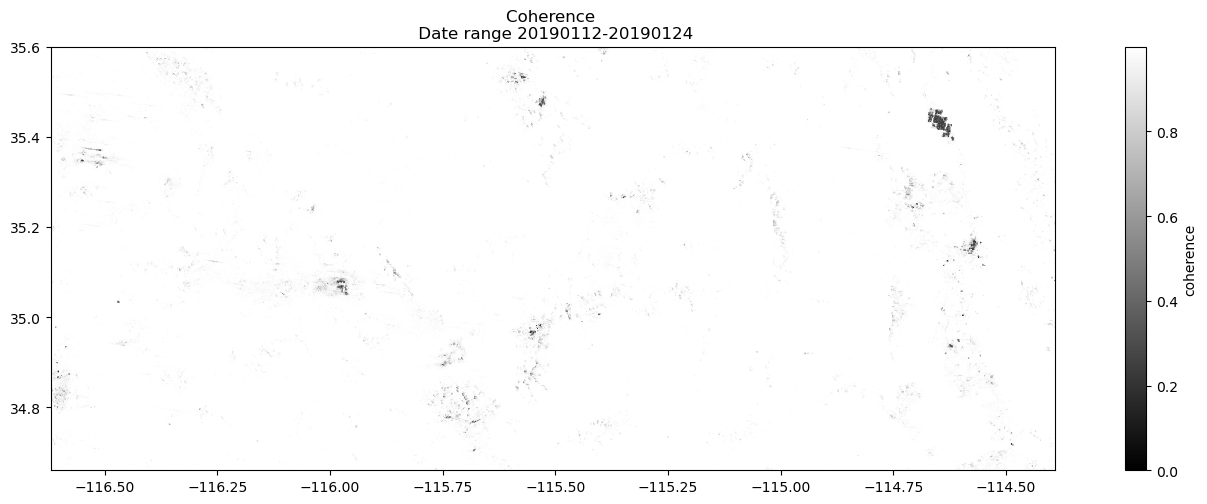

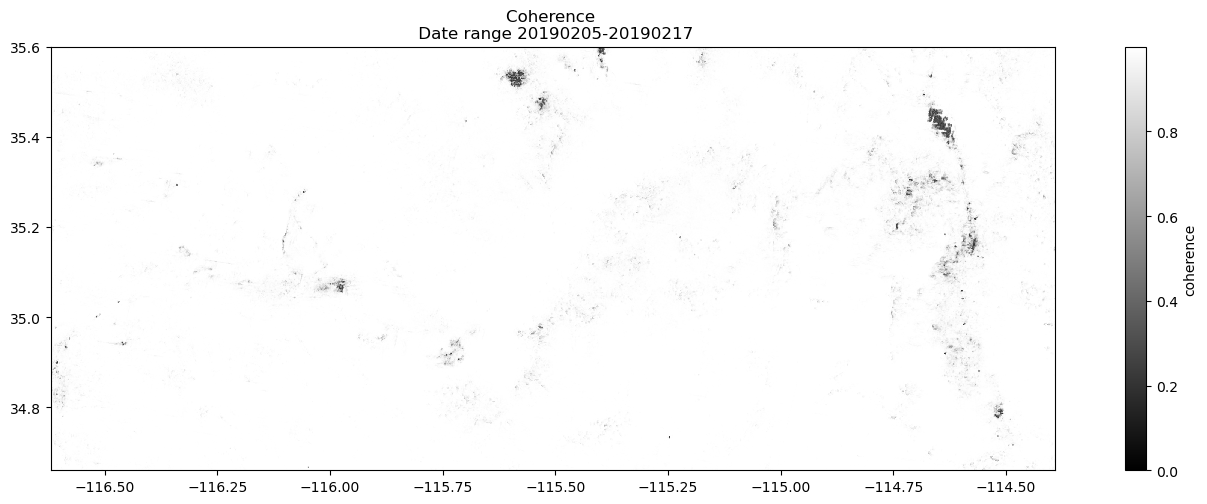

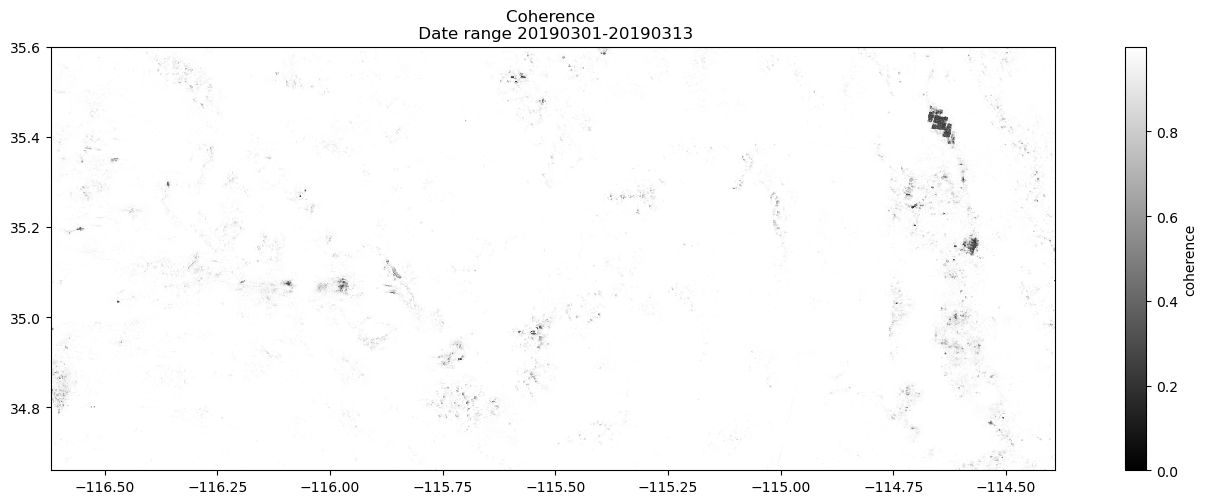

In [46]:
cmap_obj = copy.copy(plt.get_cmap('gray'))

for ifg_ndx in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.imshow(insar_coherence[ifg_ndx], cmap=cmap_obj, interpolation='nearest', extent=(W, E, S, N))
    ax.set_title(f"Coherence "
                 f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')}")
    cbar1 = fig.colorbar(img1, ax=ax)
    cbar1.set_label('coherence')

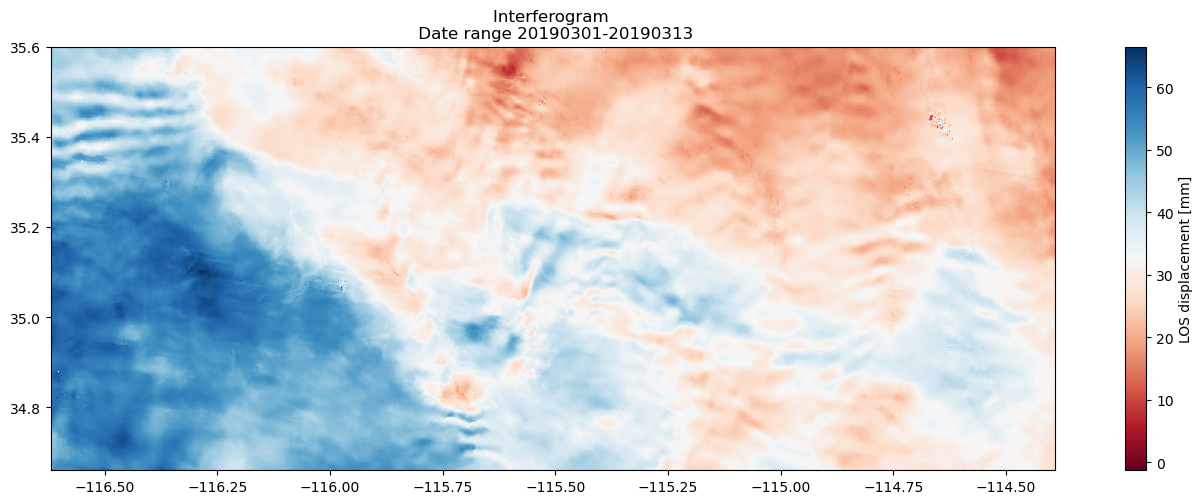

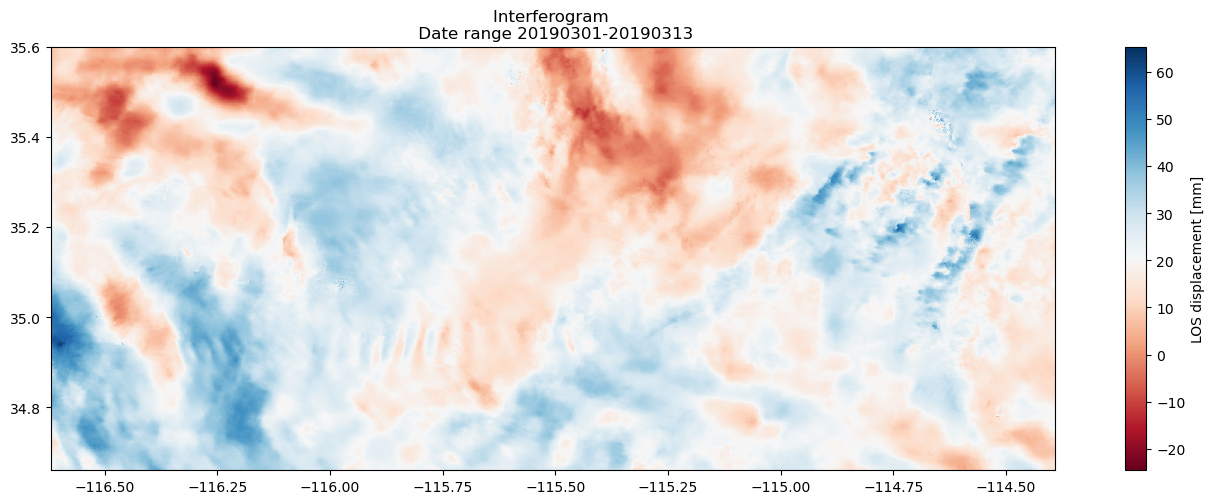

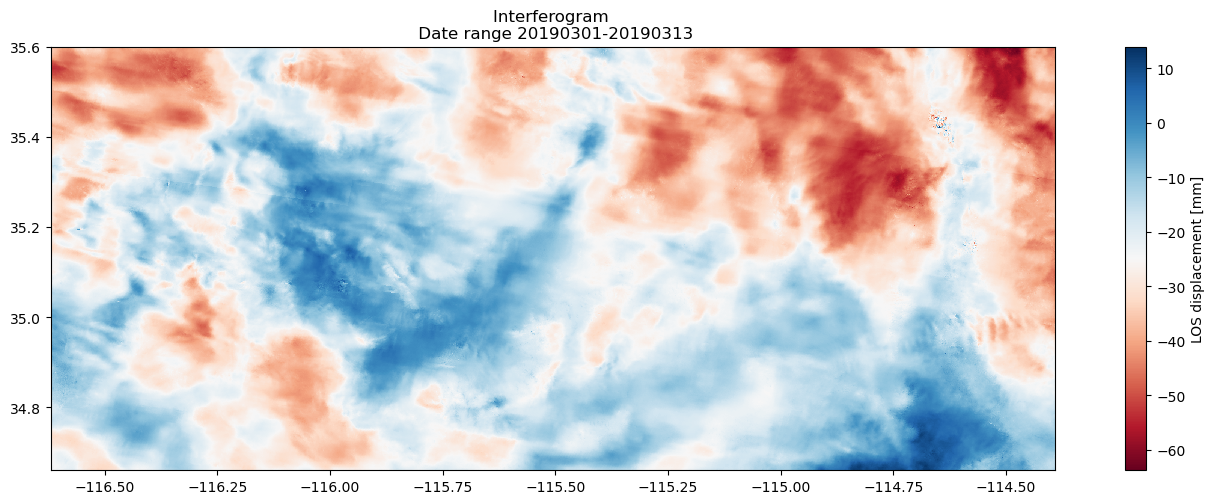

In [47]:
cmap_obj = copy.copy(plt.get_cmap(cmap))

for ifg_ndx in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.imshow(insar_displacement[ifg_ndx], cmap=cmap_obj, interpolation='nearest', extent=(W, E, S, N))
    ax.set_title(f"Interferogram "
                 f"\n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    cbar1 = fig.colorbar(img1, ax=ax)
    cbar1.set_label('LOS displacement [mm]')

<a id='transient_pair2'></a>
### 6.2. Randomly Sample Pixels and Pair Them Up

Calculate the coordinate for every pixel:

In [49]:
X0,Y0 = load_geo(insar_metadata)
X0_2d, Y0_2d = np.meshgrid(X0, Y0)

For each interferogram, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

In [50]:
# Determine the distance and phase difference between site pairs
dist = []; rel_measure = []
for ifg_ndx in range(n_ifgs):
    dist_i, rel_measure_i = samp_pair(X0_2d, Y0_2d, insar_displacement[ifg_ndx], num_samples=1000000)
    dist.append(dist_i)
    rel_measure.append(rel_measure_i)

Show the statistical property of selected pixel pairs:

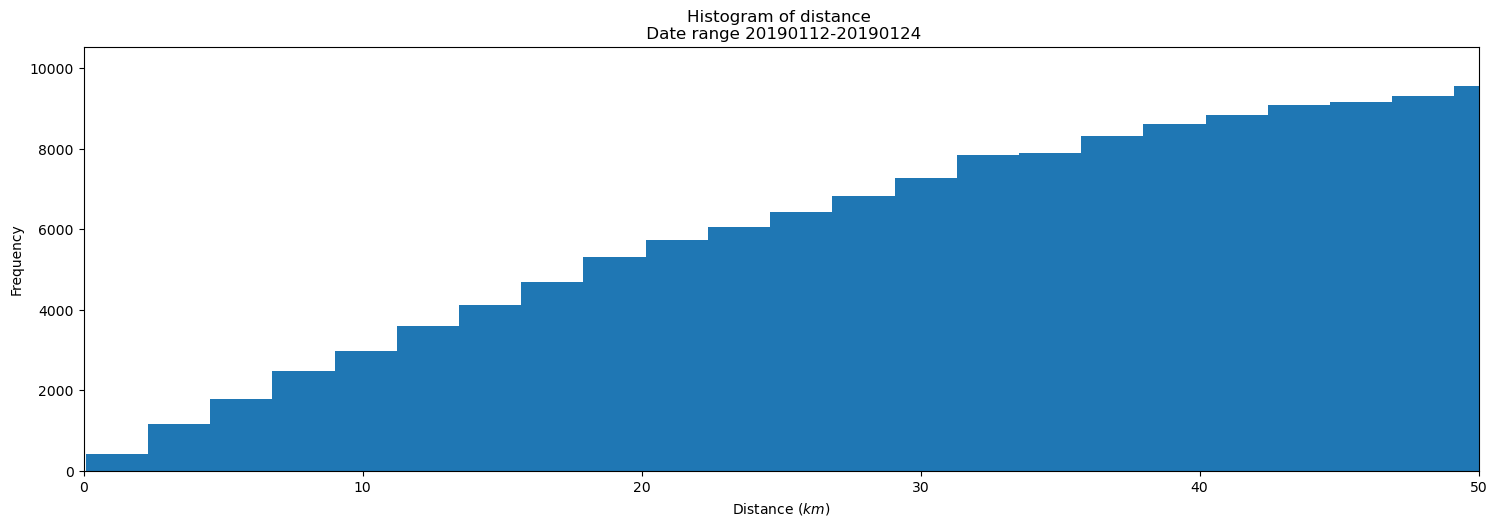

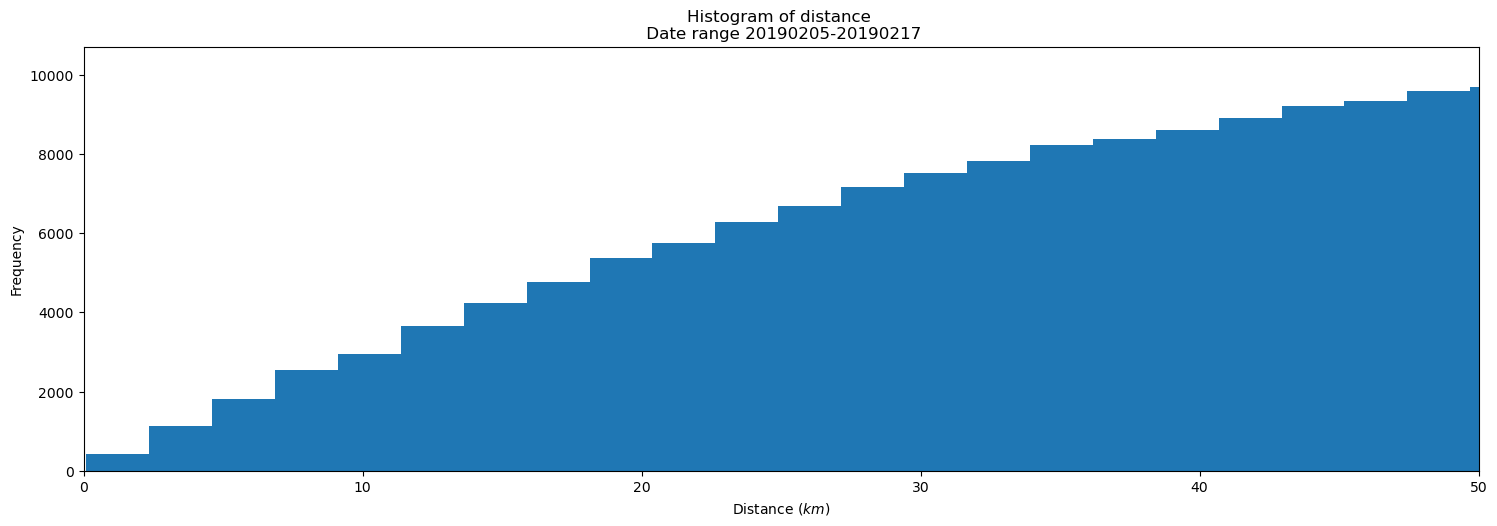

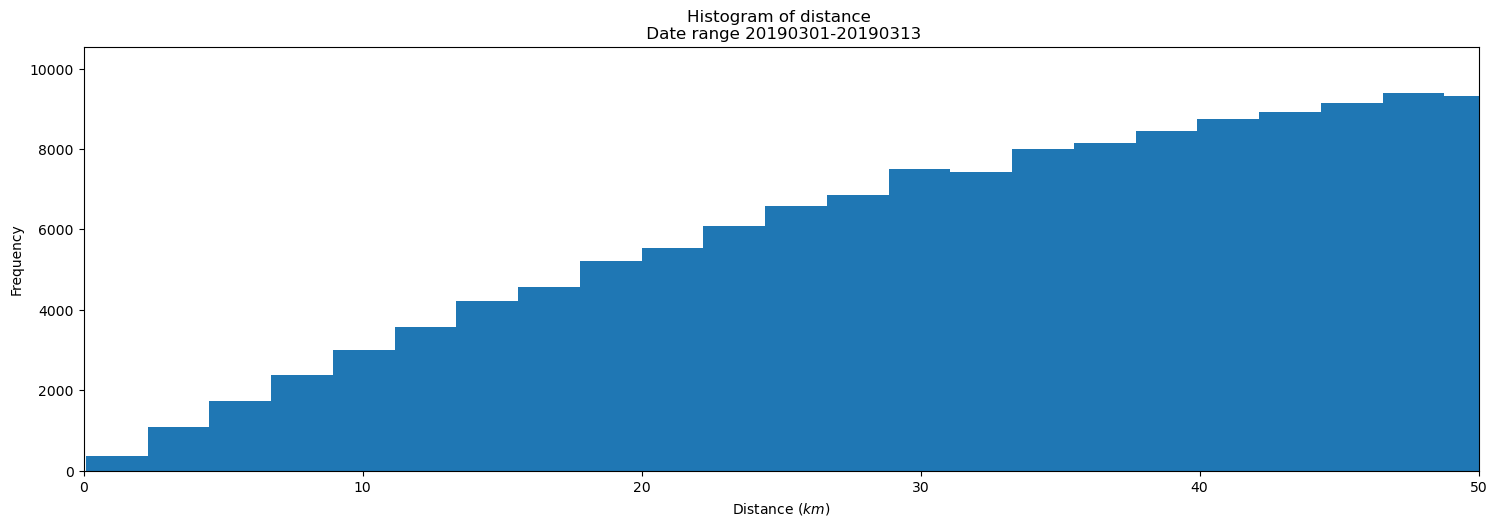

In [51]:
# Plot histogram of distances between pixel pairs
for ifg_ndx in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(dist[ifg_ndx], bins=100)
    ax.set_title(f"Histogram of distance "
                 f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Distance ($km$)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 50)

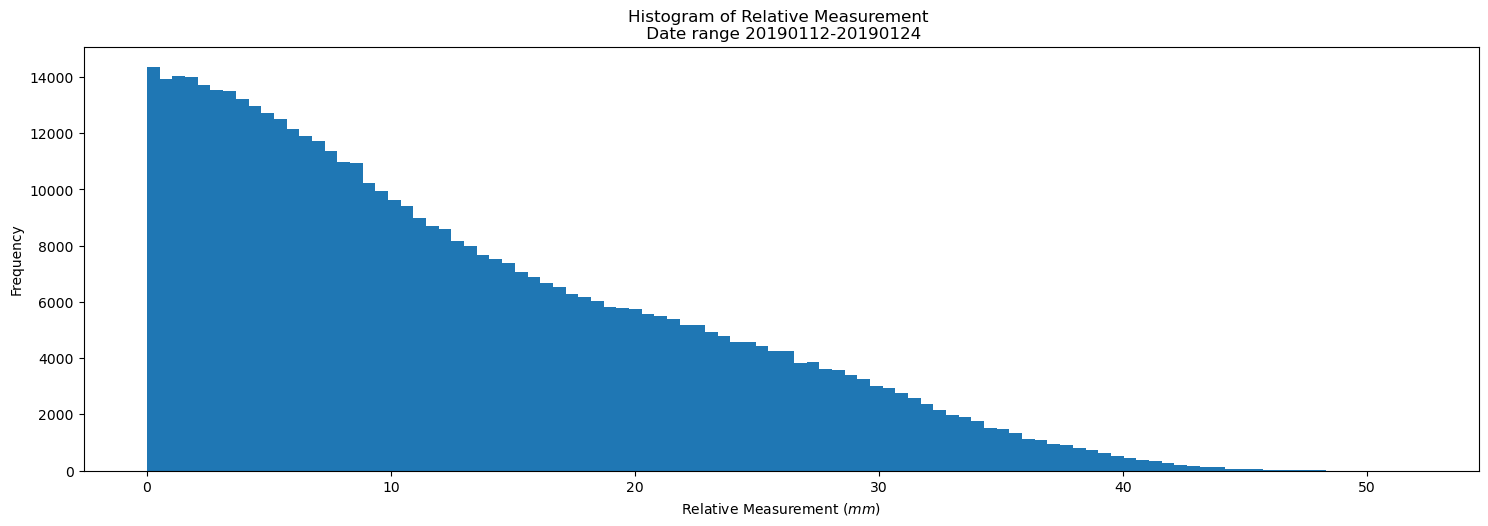

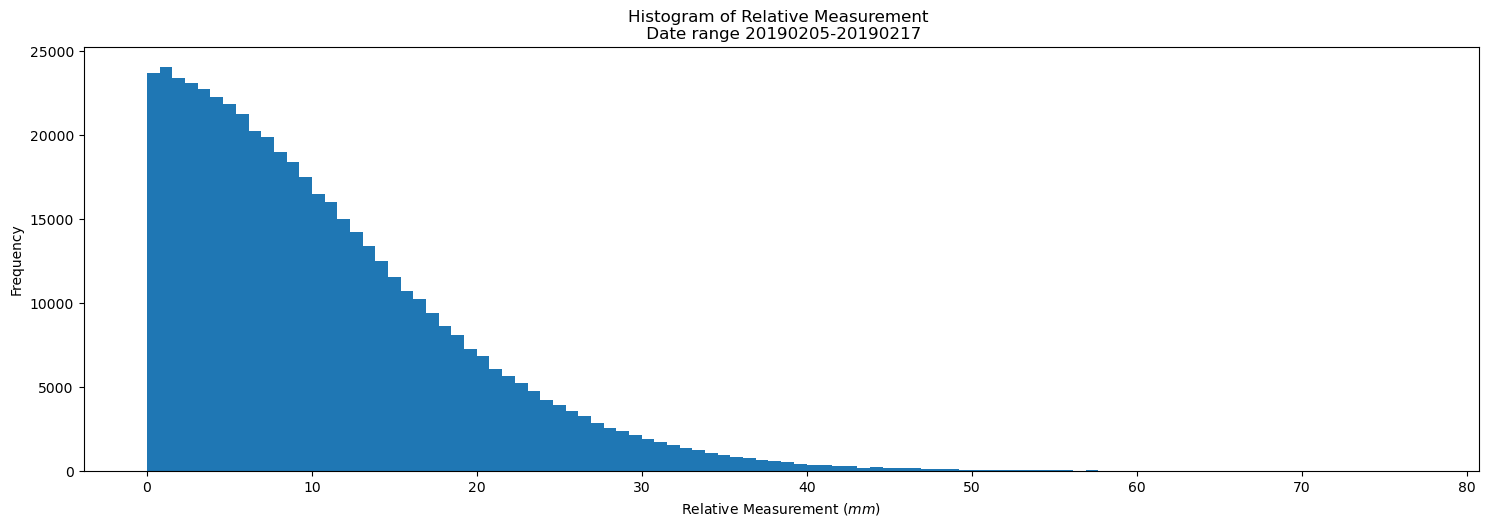

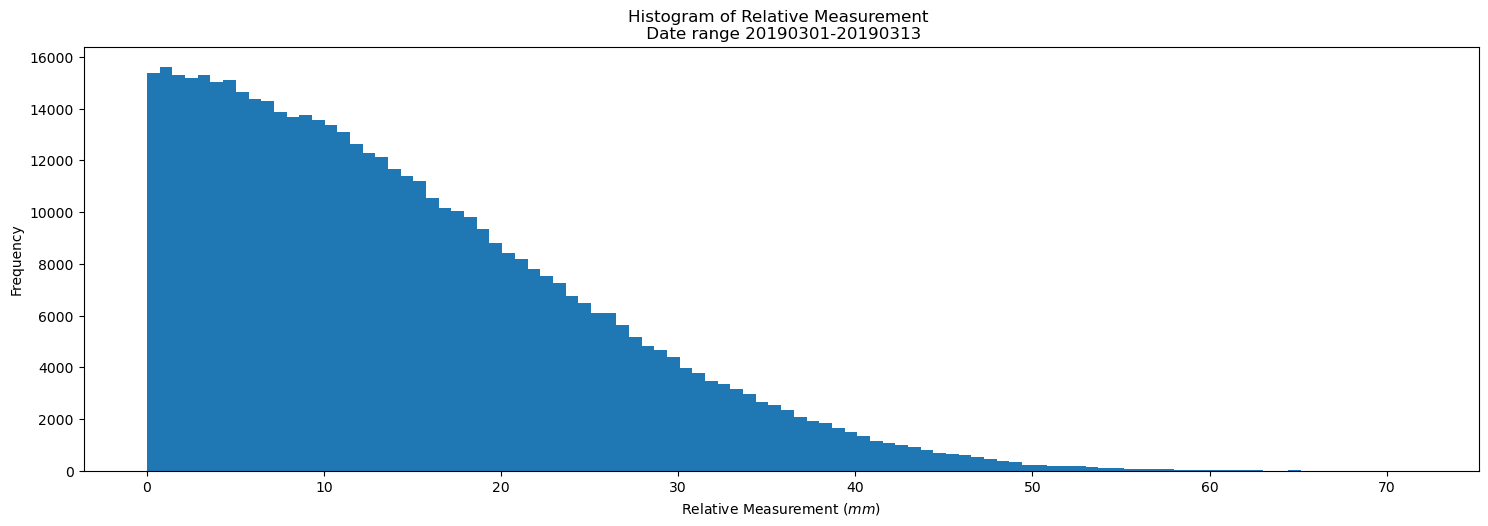

In [52]:
# Plot histogram of relative measurements
for ifg_ndx in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(rel_measure[ifg_ndx], bins=100)
    ax.set_title(f"Histogram of Relative Measurement "
                 f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Relative Measurement ($mm$)')
    ax.set_ylabel('Frequency')

We have got data used of approach 2:
- `dist`: distance of pixel pairs,
- `rel_measure`: relative measurement of pixel pairs,
- `ifgs_date`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_bin2'></a>
### 6.3. Validate the requirement based on binned measurement residuals

In [53]:
# Define number of interferograms
n_ifgs = len(ddiff_dist_ap1)
print(f"Analyzing {n_ifgs} interferograms")

Analyzing 3 interferograms


Bin all measurement residuals to check if they pass the requirements or not:

In [54]:
# Define bins over distance requirement
n_bins = 10
bins = np.linspace(0.1, 50.0, num=n_bins+1)

In [55]:
# Number of points for each ifgs and bins
n_all = np.empty([n_ifgs, n_bins+1], dtype=int)

# Number of points pass
n_pass = np.empty([n_ifgs,n_bins+1], dtype=int)

# Loop through interferograms
for i in range(n_ifgs):
    # Determine bin indices
    inds = np.digitize(dist[i], bins)

    # Loop through bins
    for j in range(1, n_bins+1):
        # Evaluate requirement for the i-th IFG and j-th distance bin
        rqmt = 3*(1+np.sqrt(dist[i][inds==j]))  # mission requirement for i-th ifgs and j-th bins

        # Relative measurement of i-th IFG and j-th distance bin
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)

    # Total number of residuals
    n_all[i,-1] = np.sum(n_all[i,0:-2])

    # Number of residuals that pass requirement
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [56]:
# Ratio of sample pairs that pass requirement
ratio = n_pass / n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))

# Define threshold of data points in a bin that must pass
thresthod = 0.683

#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio > thresthod

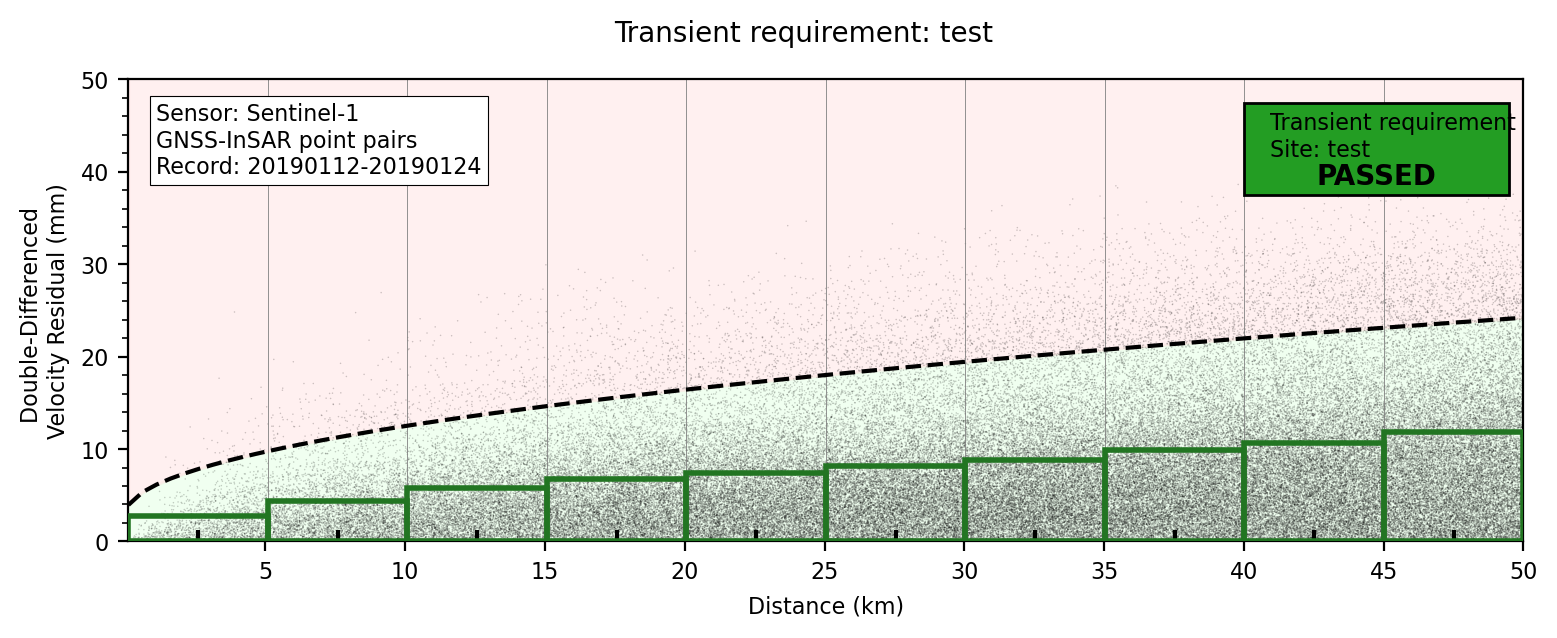

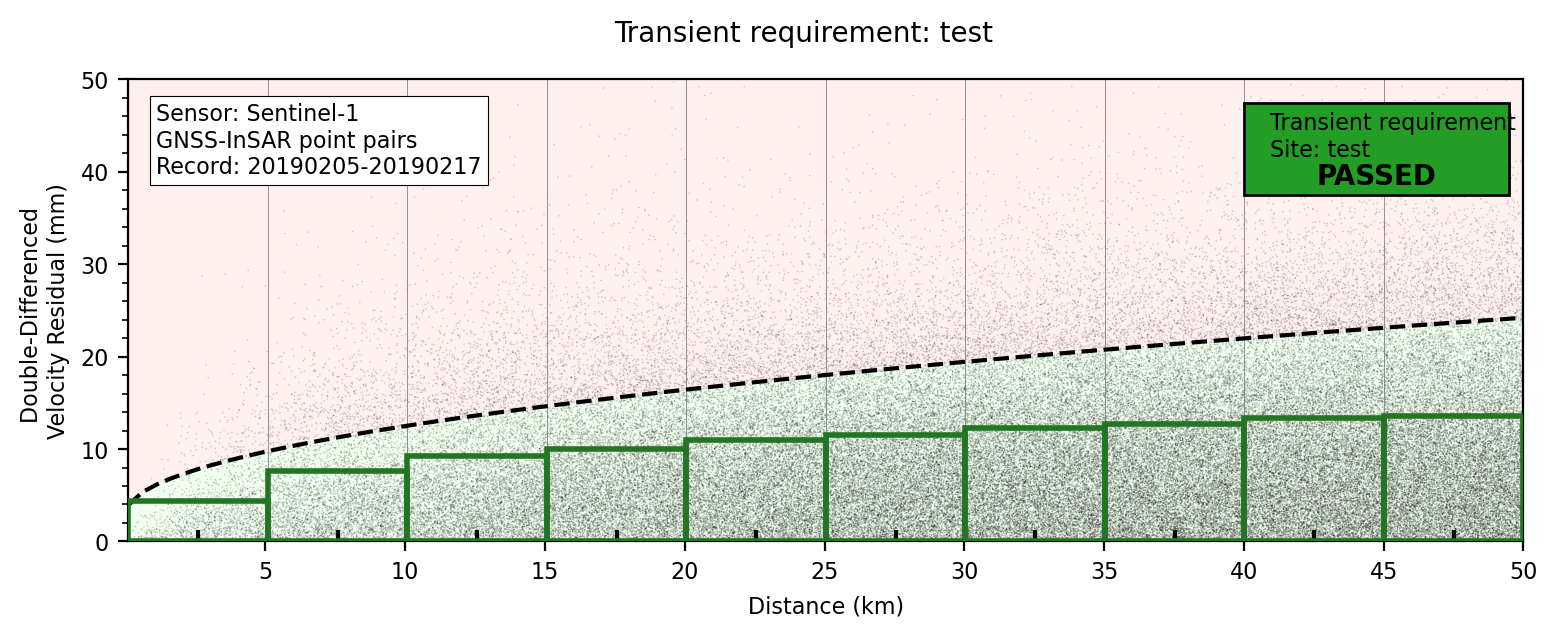

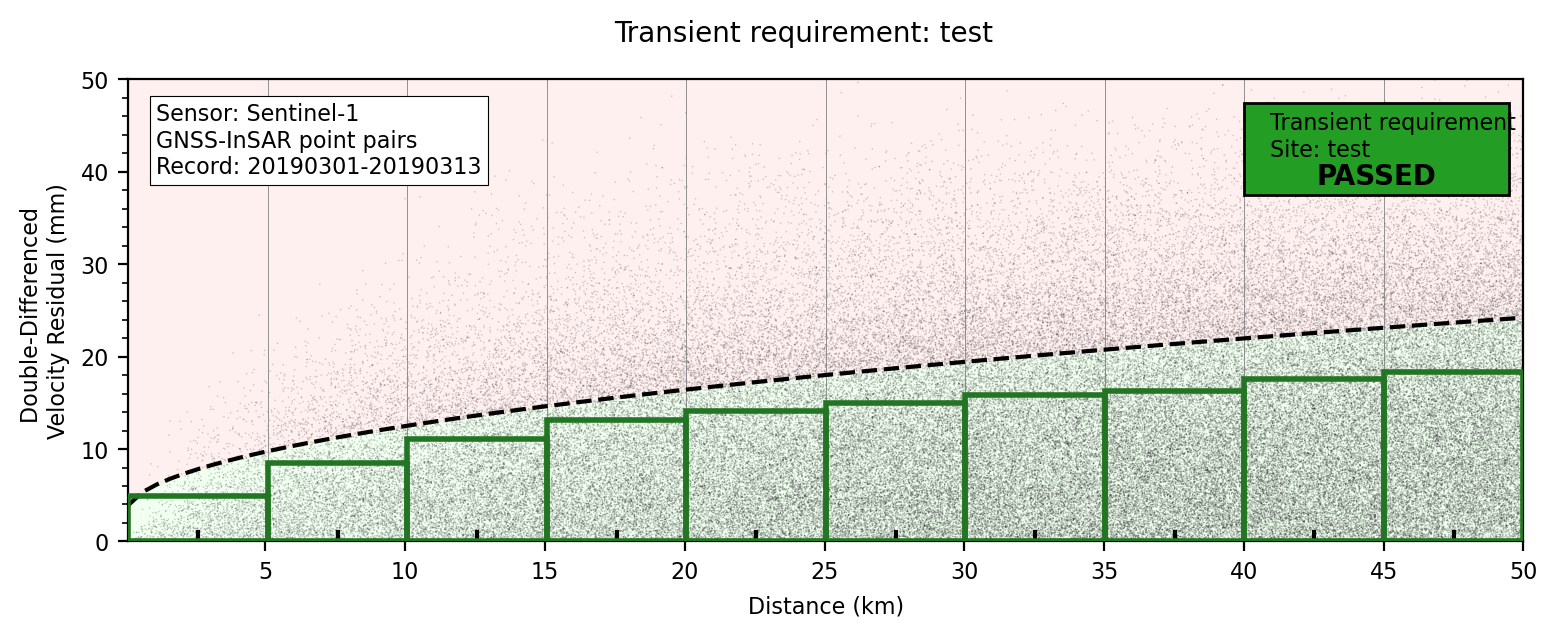

In [57]:
# Set requirement thresholds
transient_distance_rqmt = (0.1, 50)  # distances for evaluation
transient_threshold_rqmt = lambda L: 3 * (1 + np.sqrt(L))  # coseismic threshold in mm

n_bins = 10  # number of distance bins for analysis
threshold = 0.683  # fraction of Gaussian normal distribution for pass/fail


# Loop through interferograms
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Start and end dates as strings
    start_date = ifgs_date[ifg_ndx,0].strftime('%Y%m%d')
    end_date = ifgs_date[ifg_ndx,1].strftime('%Y%m%d')

    # Validation figure and assessment
    display_transient_validation(dist[ifg_ndx], rel_measure[ifg_ndx],
                                 site, start_date, end_date,
                                 requirement=transient_threshold_rqmt,
                                 distance_rqmt=transient_distance_rqmt,
                                 n_bins=n_bins,
                                 threshold=threshold,
                                 sensor='Sentinel-1',
                                 validation_type=requirement.lower(),
                                 validation_data='GNSS')

<a id='transient_result2'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [58]:
# Format evaluation success/failure as string
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f"{bins[i]:.2f}-{bins[i+1]:.2f}")
columns.append('total')

index = []
for i in range(len(ifgs_date)):
    index.append(f"{ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")

n_all_pd = pd.DataFrame(n_all, columns=columns, index=index)
n_pass_pd = pd.DataFrame(n_pass, columns=columns, index=index)
ratio_pd = pd.DataFrame(ratio, columns=columns+['mean'], index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str, columns=columns+['mean'], index=index)

Number of data points in each bin:

In [59]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20190112-20190124       1942        5224         8158        10957   
20190205-20190217       1871        5197         8034        10918   
20190301-20190313       1834        5188         8306        10981   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20190112-20190124        13288        15178        17271        18758   
20190205-20190217        13280        15514        17307        18652   
20190301-20190313        13306        15526        17202        18737   

                   40.02-45.01  45.01-50.00   total  
20190112-20190124        20051        20812  110827  
20190205-20190217        19878        20938  110651  
20190301-20190313        20001        21031  111081

Number of data points that below the curve:

In [60]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20190112-20190124       1889        5022         7862        10532   
20190205-20190217       1676        4357         6750         9529   
20190301-20190313       1649        4189         6536         8474   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20190112-20190124        12766        14518        16498        17761   
20190205-20190217        11798        13981        15705        17111   
20190301-20190313        10385        12263        13759        15177   

                   40.02-45.01  45.01-50.00   total  
20190112-20190124        19000        19652  105848  
20190205-20190217        18093        19197   99000  
20190301-20190313        16238        17236   88670

Ratio of pass:

In [61]:
# Stylized pandas table
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

<a id='transient_conclusion2'></a>
## Conclusion

Compared with percentage of total passed pairs, the mean value of percentage of passed pairs in all bin is a better indicator since it gives all bins same weight. 

In [62]:
percentage = np.count_nonzero(ratio_pd['mean']>thresthod)/n_ifgs

In [63]:
print(f"Percentage of interferograms passes the requirement (70%): {percentage}.")
if percentage >= 0.70:
    print('The interferogram stack passes the requirement.')
else:
    print('The interferogram stack fails the requirement.')

Percentage of interferograms passes the requirement (70%): 1.0.
The interferogram stack passes the requirement.


In [64]:
# Save Method 2 results to file
save_fldr = f"{dt.now().strftime('%Y%m%dT%H%M%S')}-Transient-Method2"
save_dir = os.path.join(mintpy_dir, save_fldr)

<div class="alert alert-warning">
Approach 2 final result for CentralValleyA144: 100% of interferograms passes the requirement.
</div>

<a id='transient_appendix'></a>
# Appendix: GNSS Position Plots

The relative position in LOS direction for all GNSS stations are plotted here.

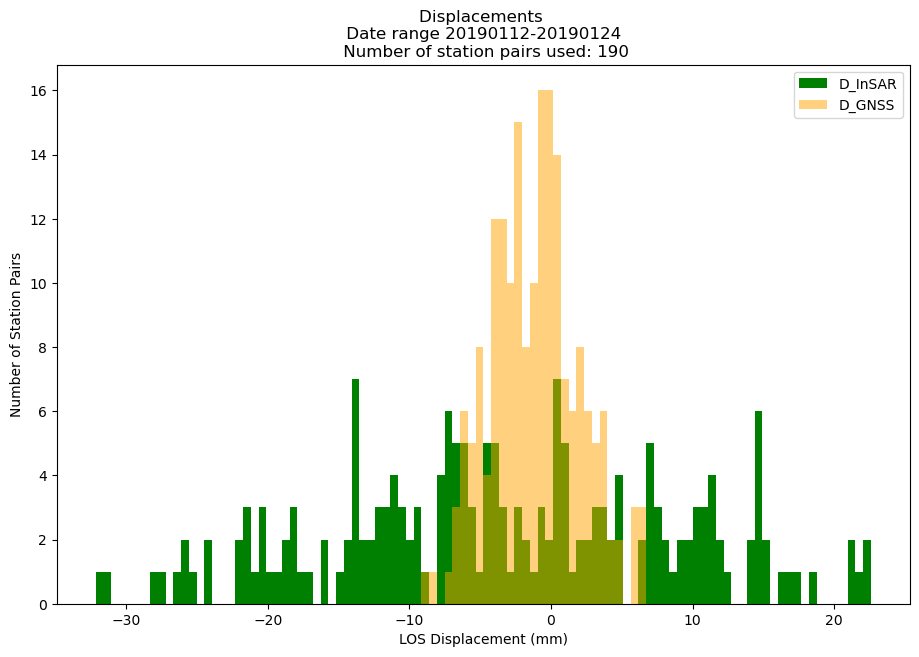

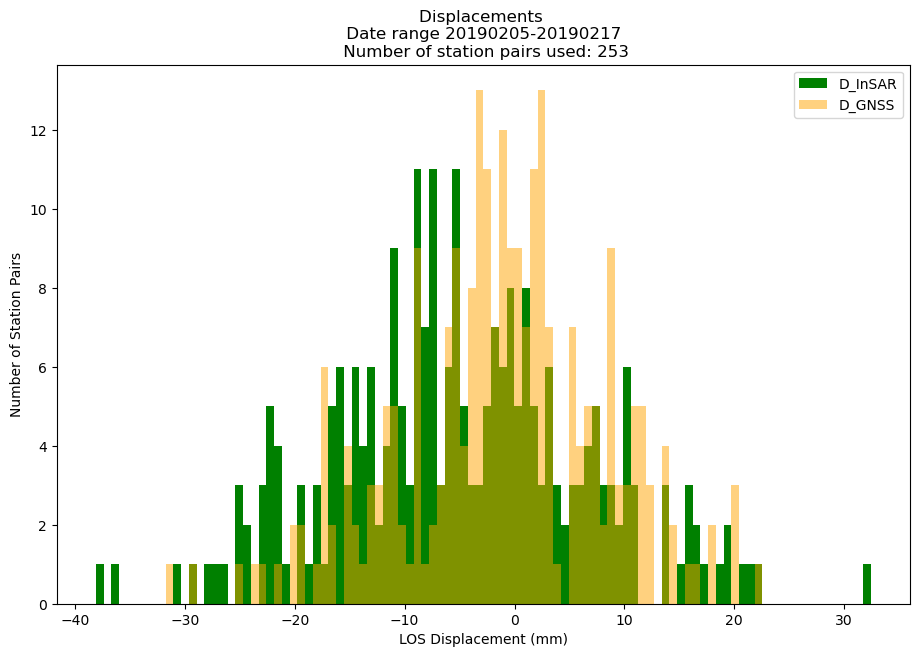

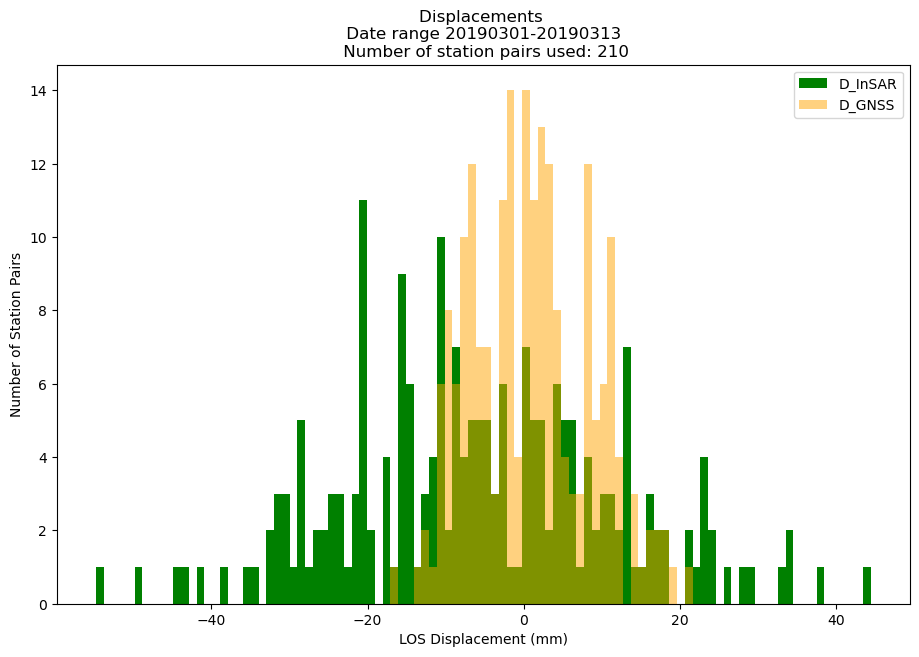

In [65]:
# Loop through interferograms
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Initialize figure
    plt.figure(figsize=(11,7))

    # Define range of displacement values
    disp_range = (min([*insar_disp[ifg_ndx],*gnss_disp[ifg_ndx]]), max([*insar_disp[ifg_ndx],*gnss_disp[ifg_ndx]]))

    # Plot histograms of InSAR and GNSS displacement values
    plt.hist(insar_disp[ifg_ndx], bins=100, range=disp_range, color = "green", label='D_InSAR')
    plt.hist(gnss_disp[ifg_ndx], bins=100, range=disp_range, color="orange", label='D_GNSS', alpha=0.5)

    # Format figure
    plt.legend(loc='upper right')
    plt.title(f"Displacements "
              f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')} "
              f"\n Number of station pairs used: {len(insar_disp[ifg_ndx])}")
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Number of Station Pairs')
    plt.show()

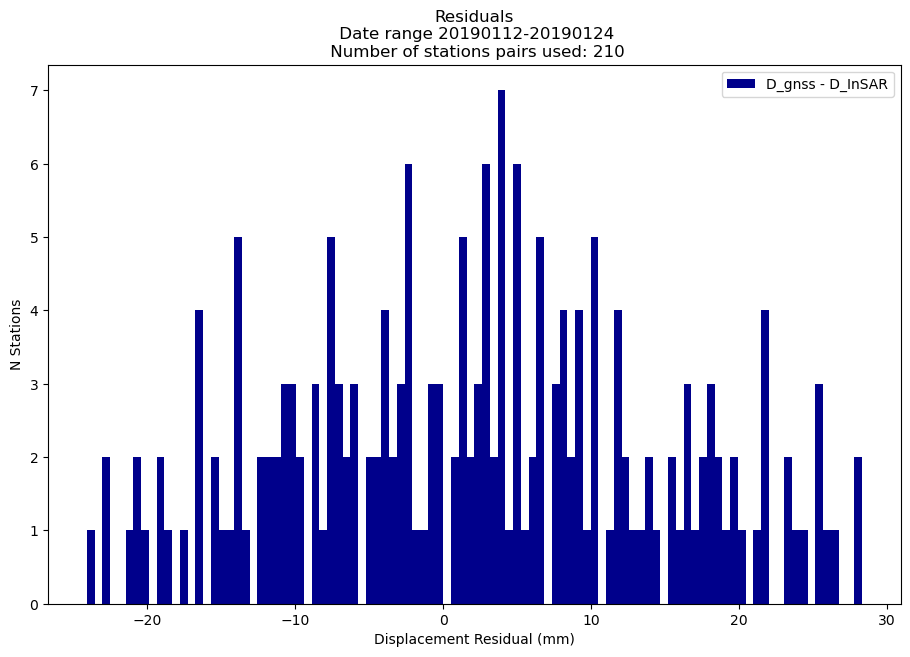

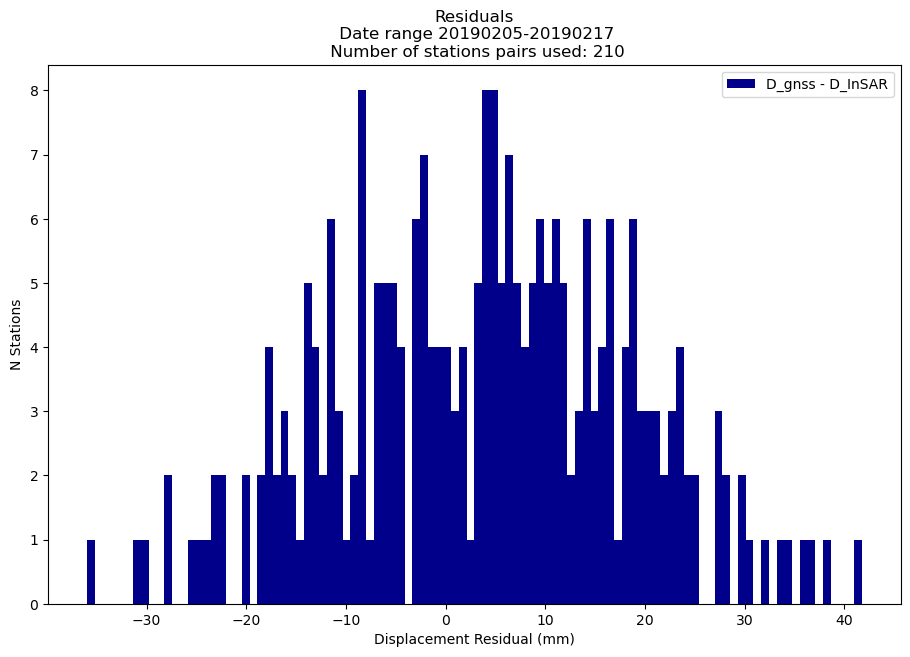

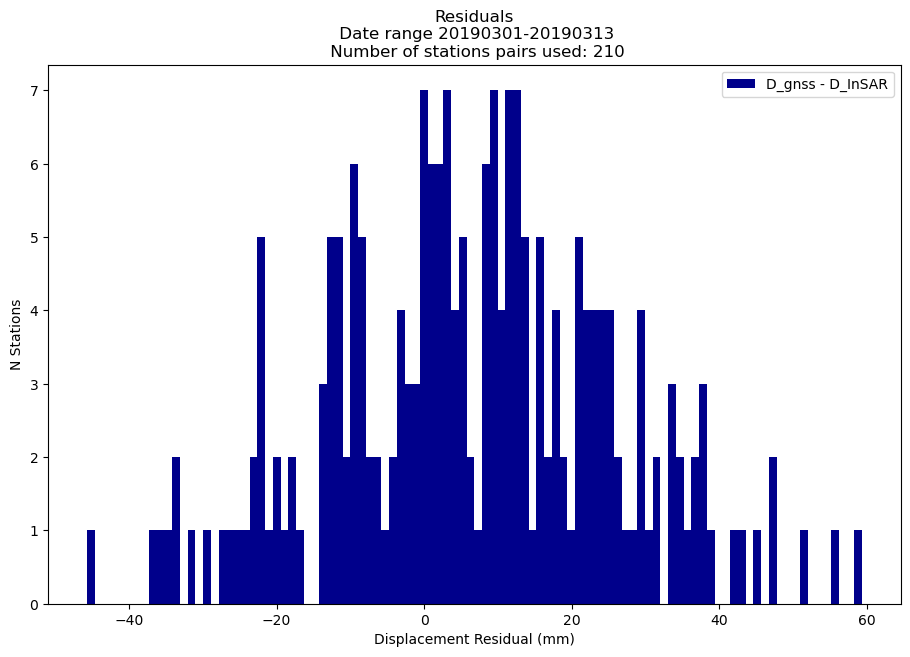

In [75]:
# Loop through interferograms
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Initialize figure
    plt.figure(figsize=(11,7))

    # Plot histogram
    plt.hist(ddiff_disp[ifg_ndx], bins=100, color='darkblue', linewidth=1, label='D_gnss - D_InSAR')

    # Format figure
    plt.legend(loc='upper right')
    plt.title(f"Residuals"
              f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')}"
              f"\n Number of stations pairs used: {len(ddiff_disp[i])}")
    plt.xlabel('Displacement Residual (mm)')
    plt.ylabel('N Stations')
    plt.show()

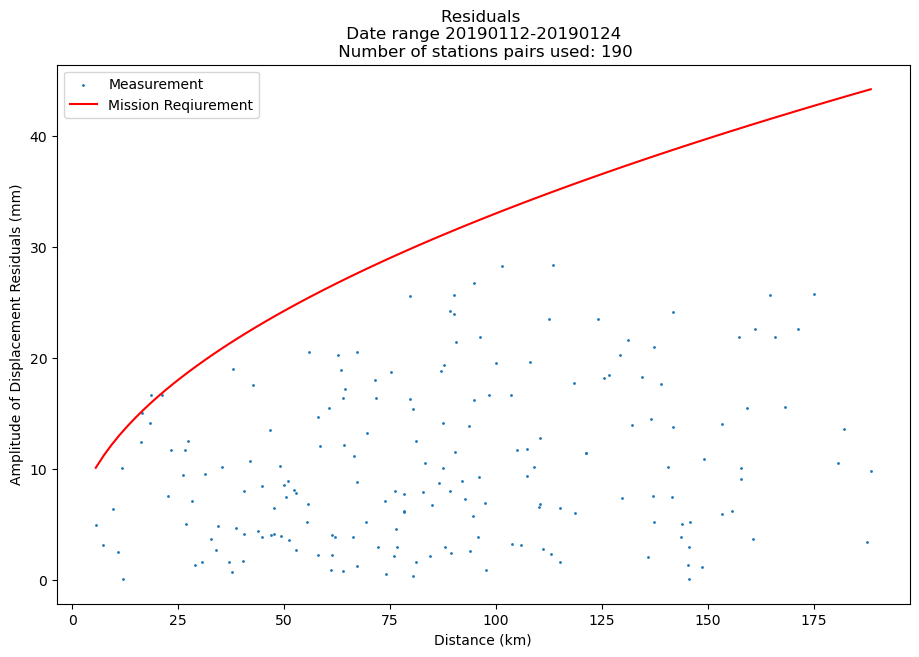

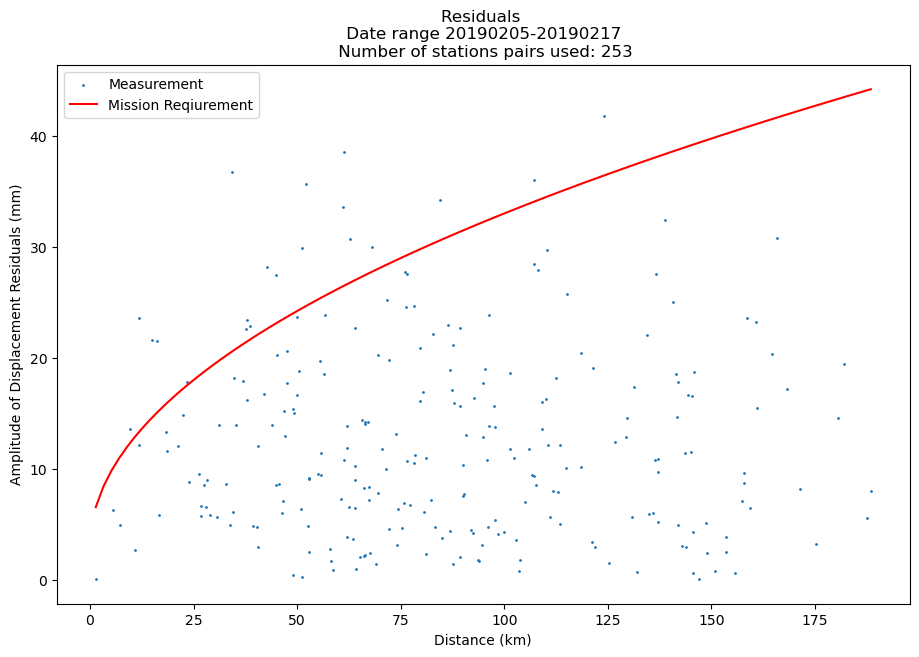

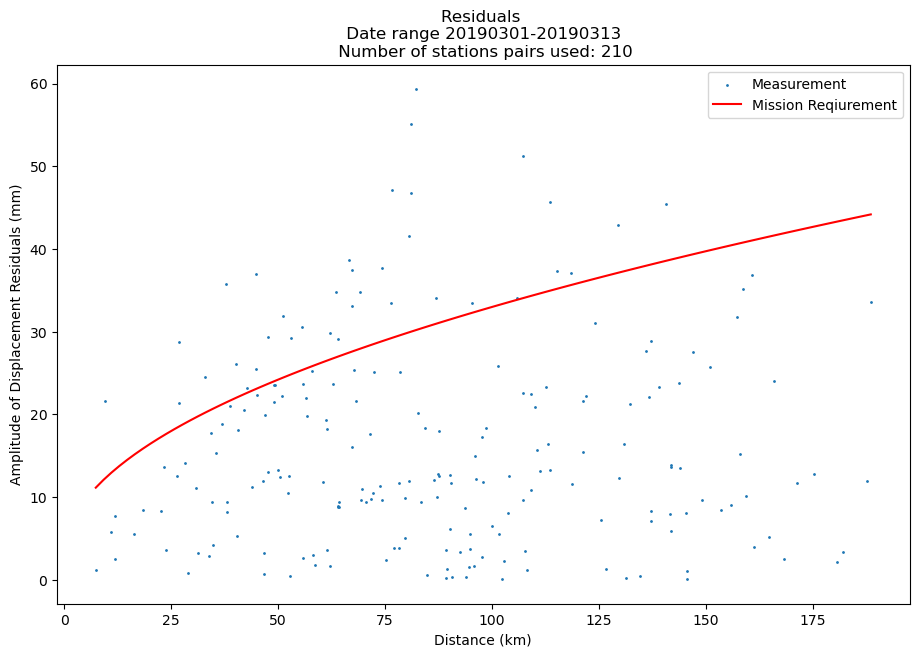

In [76]:
# Loop through interferograms
for ifg_ndx in displacement.index.get_level_values(0).unique():
    # Initialize figure
    plt.figure(figsize=(11,7))

    # Draw distance threshold
    dist_th = np.linspace(min(ddiff_dist[ifg_ndx]), max(ddiff_dist[ifg_ndx]),100)
    acpt_error = 3*(1+np.sqrt(dist_th))

    # Plot residuals
    plt.scatter(ddiff_dist[ifg_ndx], abs_ddiff_disp[ifg_ndx], s=1)
    plt.plot(dist_th, acpt_error, 'r')

    # Format plot
    plt.xlabel("Distance (km)")
    plt.ylabel("Amplitude of Displacement Residuals (mm)")
    plt.title(f"Residuals "
              f"\n Date range {ifgs_date[ifg_ndx,0].strftime('%Y%m%d')}-{ifgs_date[ifg_ndx,1].strftime('%Y%m%d')} "
              f"\n Number of stations pairs used: {len(ddiff_dist[ifg_ndx])}")
    plt.legend(["Measurement", "Mission Reqiurement"])
    plt.show()

In [66]:
gnss_time_series[1]

AZBH         AZFM        BKAP         CAB5        CDMT       GMRC  \
0   83.374023  1015.362732  306.373444  1044.865723 -317.503143  45.080410   
1   85.869011  1005.002502  299.269470  1038.768555 -321.487061  33.609303   
2   81.209274  1007.644287  300.727020  1040.054077 -324.428680  35.880791   
3   78.740326  1004.717590  299.340424  1035.690796 -323.227478  34.156448   
4   78.148216  1006.482117  300.731995  1037.224365 -320.442169  33.848003   
5   80.430481  1007.943726  306.811188  1042.766724 -318.975433  38.492603   
6   79.445778  1003.294922  298.112823  1036.182251 -321.403564  29.687002   
7   78.662872  1001.824402  297.115997  1036.729370 -326.120758  32.083652   
8   82.117912  1009.747864  301.216156  1039.951660 -321.474121  39.004772   
9   89.823929  1019.038696  308.250702  1042.810425 -317.067932  43.166286   
10  82.369682  1008.378296  302.744202  1040.940063 -323.994904  33.748402   
11  78.228172  1006.786255  297.865326  1037.074341 -321.847198  37.033676   
12  78.693359  1005.273010  295.500092  1037.389038 -327.422943  28.822617   

          HCMN        I40A        LDSW       NDAP  ...        P611  \
0  -129.124222 -333.448761  201.177780 -73.330643  ... -602.587158   
1  -143.658157 -334.065979  194.343094 -66.025467  ... -608.615662   
2  -143.679077 -336.158508  195.696594 -67.201912  ... -607.786316   
3  -145.801666 -337.586212  195.131241 -70.111099  ... -609.681763   
4  -142.908096 -335.710480  195.399292 -68.103912  ... -608.980103   
5  -145.612595 -335.928864  196.773712 -66.193848  ... -608.439697   
6  -146.816254 -340.129791  196.673874 -70.190666  ... -609.580078   
7  -148.680801 -340.054474  191.138916 -73.874596  ... -610.792908   
8  -139.832382 -334.831604  196.870499 -64.796356  ... -608.371399   
9  -140.407684 -331.907990  202.228546 -62.074692  ... -602.203552   
10 -142.217453 -339.040924  195.304214 -67.563057  ... -609.731934   
11 -146.818695 -337.378448  198.017303 -64.852592  ... -606.821289   
12 -147.642914 -343.419312  193.504639 -69.499344  ... -610.991211   

          P614        P617       P618        P619        P621        P622  \
0   760.293030  619.141113 -88.196251  211.767853 -279.145081  207.644424   
1   766.323914  605.628662 -85.929810  197.417740 -301.534912  200.351257   
2   766.257385  606.396790 -87.497353  195.717102 -302.172150  202.092285   
3   760.908264  605.738342 -88.330536  195.461456 -301.165405  202.430435   
4   765.131653  608.560059 -85.058479  198.720337 -298.596863  203.009186   
5   763.669861  616.891846 -85.514366  205.701080 -296.235596  206.392288   
6   759.815186  607.929016 -89.912209  196.303482 -304.033447  199.564117   
7   759.712646  602.782288 -91.341316  191.169205 -306.002228  197.082001   
8   769.874146  607.264404 -87.039474  201.355988 -298.983643  205.836136   
9   762.172668  608.293518 -86.400597  200.075531 -287.702911  208.406433   
10  766.130249  608.194519 -87.459564  198.148697 -294.567078  207.596771   
11  764.066589  607.535828 -88.284882  202.045380 -299.855591  202.852661   
12  761.959717  605.808960 -90.584908  191.892029 -306.664154  198.255539   

           P625       P626        RAGG  
0   1060.090088 -48.308910  864.285522  
1   1051.765381 -50.510227  859.753174  
2   1054.949585 -50.885082  859.691895  
3   1052.355835 -53.116322  858.414612  
4   1056.124390 -50.990166  861.820007  
5   1055.992188 -53.476334  862.465698  
6   1053.851318 -51.135242  859.861633  
7   1052.053589 -53.669155  856.958374  
8   1056.619629 -51.407635  863.720764  
9   1061.001465 -45.872807  866.799011  
10  1059.937988 -43.938816  861.891785  
11  1053.889160 -51.281750  859.528259  
12  1046.857666 -55.821182  853.203430  

[13 rows x 23 columns]

In [67]:
# Loop through interferograms
for ifg_ndx in range(insar_displacement.shape[0]):
    # Define start and end dates
    start_time_str = ifgs_date[ifg_ndx,0].strftime('%Y%m%d')
    end_time_str = ifgs_date[ifg_ndx,1].strftime('%Y%m%d')

    # Loop through stations in IFG
    for site_name in gnss_time_series[ifg_ndx].columns:
        print(f"Plotting GPS postion from {start_time_str} to {end_time_str} at station: {site_name}")

        # Retrieve GNSS time-series
        series = gnss_time_series[ifg_ndx, site_name]

        # Initialize figure
        plt.figure(figsize=(15,5))

        # Plot time-series data
        plt.scatter(pd.date_range(start=ifgs_date[ifg_ndx,0], end=ifgs_date[ifg_ndx,1]),series)

        # Foramt figure
        plt.title(f"station name: {site_name}")
        plt.xlabel('Time')
        plt.ylabel('Relative position in LOS direction (mm)')

        # Save figure
        plt.savefig(os.path.join(work_dir, f"{start_time_str}_{end_time_str}_{site_name}.jpg"))
        plt.close()

Plotting GPS postion from 20190112 to 20190124 at station: AZBH
Plotting GPS postion from 20190112 to 20190124 at station: AZFM
Plotting GPS postion from 20190112 to 20190124 at station: BKAP
Plotting GPS postion from 20190112 to 20190124 at station: CDMT
Plotting GPS postion from 20190112 to 20190124 at station: HCMN
Plotting GPS postion from 20190112 to 20190124 at station: I40A
Plotting GPS postion from 20190112 to 20190124 at station: LDSW
Plotting GPS postion from 20190112 to 20190124 at station: NDAP
Plotting GPS postion from 20190112 to 20190124 at station: NVLA
Plotting GPS postion from 20190112 to 20190124 at station: P603
Plotting GPS postion from 20190112 to 20190124 at station: P611
Plotting GPS postion from 20190112 to 20190124 at station: P614
Plotting GPS postion from 20190112 to 20190124 at station: P617
Plotting GPS postion from 20190112 to 20190124 at station: P618
Plotting GPS postion from 20190112 to 20190124 at station: P619
Plotting GPS postion from 20190112 to 20